<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/FoTo/(Read_Only)_May_2_FoTo_Keyw_EMB_Injection_ICDM_10Feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO (Quick Notes)

04/11/2022


1.   [Experiment] if aspects closer to each other then we only need one of them. If a user pass a list of similar aspects we only need a few of them to get the focused topics. (doesn't affect the acc of the model significantly)
2.   List item



## 03/09/22

* Its hard to find a probability density function for Ring distribution function (DECENTRALIZED.pdf paper has one but doesn't have a close form)
* KLD for ring distribution is difficult to compute since we don't have its close form function like gaussian


## 02/28/2022



1.   Try to visualize words (at last step of sim score draw a sim_score ~ β(dist (ω , κ))
2.   Keep the same NN layer for topics and keywords (embedding --> coordinate)  
3.   Try modeling the selective draw of words (Bayesian Sparse Topic model)



## 02/17/22

- Contextualized Embeddings (BERT),
- Increase Context size for lowering the level focus
- high order co-occ bad (try to model co-occurance of only the words that are similar to keyword)
- model explains similiarity we observe and not the documents
- Haven't used
1. Context of documents that have keyword (around location of keyword is the context)
2. similarity of words to the keywords based on
- how can we find a set of topics that explain the similiarity of words to the aspect (keywords)
- !!draw a word & draw a sim_score ~ gaussian(cosine_sim)


## 02/10/22

- ndcg (topwords  Vs ndcg instead of cosine), several rankings wrt. keywords? 1 ranking? (take max?)
- for each word w, max_cosine(w, keywords), rank based on max_cosine
- aggregate cosines: max, average?
- topics closed to keyword A, should use ranking by A

<h3> Injection </h3>
- use rare class A (the class has the min num docs). Select randomly one doc b not in A, inject 30% (vary 10-50%) of a ranomly doc from A to b (append). Repeat |A| times.

<h3> Other questions </h3>

- Voc size? (0.7 following ETM)
- WTM straight line?
- Topic coherence
- Topic diversity


# CODE

In [ ]:
import os
# from google import colab # works only in colab (prevents from accidentally deleting files from NMSU server)
def clear_colab():
  home_dir = '/content/'
  os.chdir(home_dir)
  !rm -r *

In [ ]:
home_dir = os.getcwd()
min_df = 0
perc_vocab = 0.7
d_data='bbc'  # reuters, twentynews, webkb, wos, crowdgender,bbc,searchsnippet,yahooanswers,agnews120k
dtype = 'short'
all_vocab = True # False
injection = False
data_islarge = False
home_dir

'/content'

In [ ]:
# !nvidia-smi

#⬅️ **0. Just Run these..**

In [ ]:
#@title Imports
# from sympy.stats import RaisedCosine, density
# from nltk.corpus import stopwords
import pandas as pd

import nltk
nltk.download('punkt')
from nltk import bigrams
import itertools
from nltk import word_tokenize
import re
from time import time
import numpy as np
import collections
import gc
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import shutil
from collections import Counter
# cos_sim = nn.CosineSimilarity(dim=-1,eps=1e-08)

### pickle
import pickle
!pip install pickle5
import pickle5
import bz2
import _pickle as cPickle


### plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sb
from matplotlib import pyplot as plt


#### torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
import subprocess


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#@title function : load / save pickle_obj

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_pkl5(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

def compressed_pickle(data,title):
  with bz2.BZ2File(title + '.pbz2', 'w') as f:
    cPickle.dump(data, f)

def decompress_pickle(file):
 data = bz2.BZ2File(file+'.pbz2', 'rb')
 data = cPickle.load(data)
 return data

## **Download Data (Short & Full Documents)**

In [ ]:
def short_text_datasets():
  if not os.path.exists("VLDB_WTM_Datasets.zip"):
    !wget -N -c https://www.dropbox.com/s/0vzwa9eagkmgi0q/VLDB_WTM_Datasets.zip
    !unzip -o VLDB_WTM_Datasets.zip
    if all_vocab == True:
      if d_data == "bbc":
        dir ='/content/content/data_'+d_data
        shutil.rmtree(dir)
        !wget -N -c https://www.dropbox.com/s/2ow6rn3xgtpg6uq/bbc_all_vocab_.zip
        !unzip bbc_all_vocab_.zip


In [ ]:
def download_data(data,dtype):
  data = data.lower()
  dtype = dtype.lower()
  # elif dtype == 'short':
  #   short_text_datasets()
  if data == "twentynews":
    !wget -N -c https://www.dropbox.com/s/7yj1yvzpw589018/twentynews_4000.zip
    !unzip twentynews_4000.zip
  elif data == 'searchsnippet' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/vu3ftyv72fodfiv/searchsnippet_all_vocab_.zip
    !unzip -o searchsnippet_all_vocab_.zip
  elif data == 'agnews120k' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/wvx9ed1rop9vjkg/agnews120k_all_vocab_.zip
    !unzip -o agnews120k_all_vocab_.zip
  elif data=='bbc' and dtype =='short' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
    !unzip -o bbc_short_all_vocab_.zip
  elif data=='bbc' and dtype =='full' and all_vocab:
    !wget -N -c https://www.dropbox.com/s/t217pxhn280njre/bbc_full_all_vocab_200iter_sent.zip
    !unzip -o bbc_full_all_vocab_200iter_sent.zip

##**Data Loading functions**

In [ ]:
def load_data(d_data,dtype,generated):
  dir= home_dir+'/content/data_'+d_data+'/'+dtype
  # dir ='/content/content/data_'+d_data+'/'+dtype
  os.chdir(dir)
  data_preprocessed=load_obj_pkl5("data_preprocessed_"+d_data+"_"+dtype)
  data_preprocessed_labels=load_obj_pkl5("data_preprocessed_labels_"+d_data+"_"+dtype)
  if generated == False:
    embeddings=load_obj_pkl5("embeddings_"+d_data+"_"+dtype)
  # generated_embeddings=load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  elif generated==True:
    embeddings = load_obj_pkl5("generated_embeddings_"+d_data+"_"+dtype)
  os.chdir(home_dir)
  return data_preprocessed,data_preprocessed_labels,embeddings,load_data.__name__

def load_20News_sentences():
  embeddings = load_obj('embeddings_twentynews_sent')
  data_preprocessed = load_obj('data_twentynews_preprocessed_sent')
  data_preprocessed_labels = load_obj("data_twentynews_labels_sent")
  doc_sent_id = load_obj('doc_id_sent_twentynews')
  return data_preprocessed,data_preprocessed_labels,embeddings,doc_sent_id,load_20News_sentences.__name__

def load_20News_reuters():
  data_preprocessed = load_obj('data_reuters_preprocessed')
  data_preprocessed_labels = load_obj("data_reuters_labels")
  embeddings = load_obj('embeddings_reuters')
  data_preprocessed.extend(load_obj('data_20News_preprocessed'))
  data_preprocessed_labels.extend(load_obj("data_20news_preprocessed_labels"))
  embeddings.update(load_obj('embeddings_20news'))
  return data_preprocessed,data_preprocessed_labels,embeddings,load_20News_reuters.__name__

## get_keywords

In [ ]:
def get_keywords(data):
  keywords_arxiv = ['molecular ','stimulation','liquid','fluid']
  keywords_webkb = ['student','department','india']
  keywords_r52 = ['mutual','fund','market','money']

  keywords_WoS = ['pediatric','protein','clone']
  keywords_20News_Reuters = ['oil','price','opec','bpd','barrel','saudi','production','mln','crude']

  # keywords_reuters = ['company', 'analyst', 'offer', 'pct', 'takeover', 'merger', 'record', 'dividend', 'pay', 'stock']
  # keywords_reuters = ['stock', 'dividend', 'inc']
  keywords_reuters = ['oil','crude','ship']
  # keywords =['stock']
  # keywords_reuters = ['usa']

  keywords_crowdgender = ['housewife','girl','beautiful','blonde']

  keywords_20News = ['sport','game','baseball']
  # keywords_20News = ['looking' ,'add', 'voice' ,'input', 'capability', 'user', 'interface']

  # keywords_bbc=['fuel','reserve','oil']
  # keywords_bbc=['fuel','oil','game','win']
  # keywords_bbc=['fuel','oil','crude']
  # keywords_bbc=['fuel','usa'] #,'politics'
  # keywords_bbc = ['stock','apple','increase']
  # keywords_bbc = ['microsoft','computer']
  #keywords_bbc = ['apple','microsoft', 'stock', 'sport','league','rugby']
  # keywords_bbc = ['apple','stock']
  # keywords_bbc = ['fuel']
  # keywords_bbc = ['microsoft','fuel']

  # keywords_bbc = ['politics','security','minister']
  #keywords_bbc = ['sport','league','rugby']
  # keywords_bbc = ['star','singer']
  #keywords_bbc = ['health', 'family']
  #keywords_bbc = ['cancer', 'study']

  keywords_bbc = ['sport', 'game', 'oil', 'fuel']
  ## all infreq
  # keywords_bbc = ['mcdonald', 'food','delivery']
  #keywords_bbc = ['business','entertainment','politics']
  # keywords_bbc = ['clumsy','food']
  # keywords_bbc= ['boost','december']

  # keywords_searchsnippet = ['politics','drama','minister']
  keywords_searchsnippet = ['korean','drama']

  # keywords_bbc = ['game', 'digital']

  keywords_yahooanswers = ['anger','hate','crime']
  # keywords_agnews = ['computer','apple','microsoft']
  keywords_agnews = ['auto','gasoline']

  data = data.lower()
  if data=='reuters': keywords = keywords_reuters
  elif data=='twentynews':keywords = keywords_20News
  elif data=='crowdgender':keywords = keywords_crowdgender
  elif data=='webkb':keywords = keywords_webkb
  elif data=='bbc': keywords = keywords_bbc
  elif data=='searchsnippet': keywords = keywords_searchsnippet
  elif data=='yahooanswers': keywords = keywords_yahooanswers
  elif data=='agnews120k': keywords = keywords_agnews
  elif data=='wos': keywords = keywords_WoS
  else:
    print('keyword list not found!!!')
  return keywords

##DESM Score Function

In [ ]:
def cosine_similarity_desm_docs(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      if(train_vec[d][v] > 0):
        doc_bar.add_(train_vec[d][v] * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec[d][v]
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list

In [ ]:
def cosine_similarity_desm_docs_forlarge(query_list, train_vec, vocab, embeddings):
  num_docs = train_vec.shape[0]
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      train_vec_val = train_vec[d].toarray()[0][v]
      if(train_vec_val > 0):
        doc_bar.add_(train_vec_val * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec_val
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list


## functions (Plot_loss, get_topwords, get_Z, get_Contour, print_Topics)

In [ ]:
#@title plot F(n) - desm + doc containing keyword

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,c=C)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='red')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='red')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_desm_doConKey(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,C1,C2,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.6,s=100)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,alpha=1.0,marker="X",s=100)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='red')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='red')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
def vocab_filtered_data(doc,vocab):
  doc = word_tokenize(doc)
  doc = filter(lambda x: x in vocab, doc)
  doc = ' '.join(e for e in doc)
  return doc

In [ ]:
def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def cal_knn(coordinate, label):
    output = []
    for n_neighbors in [10, 20, 30, 40, 50]:
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
        neigh.fit(coordinate, label)
        output.append(neigh.score(coordinate, label))
    return output

In [ ]:
def list_of_tensors_to_tensor(loT):
  stacked_tensor = torch.stack(loT)
  return stacked_tensor

def get_labels_dict(unique_labels):
  labels_dict = {}
  for l in unique_labels:
    labels_dict[l] = 'C'+str(unique_labels.index(l))
  return labels_dict

def get_topwords(beta, id_vocab,topwords):
    topic_indx = 0
    topwords_topic = []
    topic_topwords = topwords
    for i in range(len(beta)):
        topwords_topic.append( str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-topic_topwords - 1:-1]]))
        topic_indx+=1
    return topwords_topic


def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}

    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))

    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))

    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))

    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)

    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

def print_Topics(topwords):
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab,topwords)
  topword_topics_list=[]
  for topwords in topword_topics:
      topword_topics_list.append(topwords.split())
      print(topwords)
  print("---"*10)

def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)

def colored_print_Topics(topwords,beta):
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab,topwords)
  topword_topics_list=[]
  for topwords in topword_topics:
    topic = topwords.split()[0]
    words_in_topwords = topwords.split()[1:]
    print(topic,end=" ")
    for word in words_in_topwords:
      if word in keywords:
        print(colored(255, 0, 0, word),end=" ") # keyword == red
      elif word in bigram_coocurring_word_list:
        print(colored(0, 0, 255, word),end=" ") # co-occuring == blue
        # print(colored(255, 255, 255, word),end=" ") # co-occuring == blue
      elif word in most_similar_word_list:
        print(colored(0, 255, 0, word),end=" ") # similar == green
      else: print(word,end=" ") # other words == white
    print('')
  print("---"*10)

In [ ]:
import plotly.graph_objects as go
def plot_relative_diff(x,y,y2,name2,title,yaxis_title,xaxis_title):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y,
                      mode='lines+markers',
                      name="FoTo"))
  fig.add_trace(go.Scatter(x=x, y=y2,
                      mode='lines+markers',
                      name=name2))

  fig.update_layout(title=title,
                    yaxis_title=yaxis_title,
                    xaxis_title=xaxis_title)

  fig.show(renderer='colab')

In [ ]:
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

def plot_fig(zx, labels_list, zphi, query_center,query_words,hv_qwords,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    label_colors_dict = get_labels_dict(sorted_unique_labels+['keywords'])
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=label_colors_dict,s=50)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    ax.text(query_center[0],query_center[1], 'X' ,c='black',weight='bold',fontsize=20)
    # ax.text(0,0, 'X' ,c='black')

    if hv_qwords:
      for i in range(len(query_words)):
        if (i==len(query_words)-1):
          ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold',fontsize=13)
        else:
          ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold',fontsize=13)

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx),fontsize=13)



def get_Z(X,Y):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])

      norms[i][j] = torch.norm(v)
      Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)

      # norms[i][j] = (v-query_center.T).pow(2).sum(-1)
      # Z[i][j]=torch.exp(-0.5 * norms[i][j]/mu_div)
  return Z

def get_Contour(ax,x_list,lim):
  xlist = np.linspace(-lim, lim, 200)
  ylist = np.linspace(-lim, lim, 200)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)


def get_gpu_memory_map():
    """Get the current gpu usage.
    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = np.array([int(x) for x in result.strip().split('\n')])
    # gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory

def auto_select_gpu(memory_threshold = 7000, smooth_ratio=200, strategy='greedy'):
    gpu_memory_raw = get_gpu_memory_map() + 10
    if strategy=='random':
        gpu_memory = gpu_memory_raw/smooth_ratio
        gpu_memory = gpu_memory.sum() / (gpu_memory+10)
        gpu_memory[gpu_memory_raw>memory_threshold] = 0
        gpu_prob = gpu_memory / gpu_memory.sum()
        cuda = str(np.random.choice(len(gpu_prob), p=gpu_prob))
        print('GPU select prob: {}, Select GPU {}'.format(gpu_prob, cuda))
    elif strategy == 'greedy':
        cuda = np.argmin(gpu_memory_raw)
        print('GPU mem: {}, Select GPU {}'.format(gpu_memory_raw[cuda], cuda))
    return cuda

# **1. Prepare Data**

In [ ]:
#### Data Downloading ####
download_data(d_data,dtype) ### Run Once

--2022-05-03 00:24:21--  https://www.dropbox.com/s/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip [following]
--2022-05-03 00:24:21--  https://www.dropbox.com/s/raw/4mxikpqoj26rmsg/bbc_short_all_vocab_.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc5eb364f18dfeef72f99b1ca62.dl.dropboxusercontent.com/cd/0/inline/BkiORLF2U4lkfgOhfmvUqSgfTBcuWXO79PzvXO7uIFKgBH7-x0JPX2LIYns_gXYfndXflaQip4DHkVSptawHu_NCKk1fyL8ZSxBP4mpJqwoa84YkRblBHM1OAnO-zhC_W_XuCMal4_oa3u8MhlIgIRD8fNsPTUiIIR9m6JYxQvsVTA/file# [following]
--2022-05-03 00:24:22--  https://ucc5eb364f18dfeef72f99b1ca62.dl.dropboxusercontent.com/cd/0/inline/BkiORLF2U4lkfgOhfmvUqSgfTBcuWXO7

In [ ]:
# ##### Data loading #####
loaded_data = load_data(d_data,dtype,generated=False)
##########################

data_preprocessed , data_preprocessed_labels , embeddings, name = loaded_data
max_features=int(len(embeddings)*perc_vocab)
sorted_unique_labels = sorted(set(data_preprocessed_labels))

# for d in range(len(data_preprocessed)):
#   data_preprocessed[d] = doc_remove_extra_stopwords(data_preprocessed[d])
print(name,d_data,len(data_preprocessed_labels),len(data_preprocessed),len(embeddings),max_features)

load_data bbc 2224 2224 5733 4013


### injection

In [ ]:
if injection:
  d = Counter(data_preprocessed_labels)
  rare_class = min(d, key=d.get)
  rare_class_nlabels = d[rare_class]

  np.random.seed(seed=len(data_preprocessed_labels))
  np_data = np.asarray(data_preprocessed)
  np_labels = np.asarray(data_preprocessed_labels)

  to_change = np.where(np_labels != rare_class)[0]
  to_change_with  =  np.where(np_labels == rare_class)[0]
  rand_perm_k_to_change_with = np.random.permutation(to_change_with)
  rand_perm_k_to_change = np.random.permutation(to_change)

  to_change_with_docs = np_data[rand_perm_k_to_change_with]
  to_change_docs =  np_data[rand_perm_k_to_change]
  print('Before Injection - \n',data_preprocessed[rand_perm_k_to_change[0]])
  # dict_docs[to_change_label] = to_change_docs
  p=0.35
  n_docs_changed = 0
  changed_docs = []
  for i in range(rare_class_nlabels):
    words = to_change_with_docs[i].split()
    words_to_change = to_change_docs[i].split()
    perc = int(len(words_to_change)*p)
    if perc == 0:
      continue
    # perc_to_change = min(perc1,perc2)
    # random.shuffle(words)
    # random.shuffle(words_to_change)
    n_docs_changed = n_docs_changed+1
    to_change_docs[i] = " ".join(words[:perc] + words_to_change)
    changed_docs.append(to_change_docs[i])
    data_preprocessed[rand_perm_k_to_change[i]] = to_change_docs[i]
  print('After Injection - \n',data_preprocessed[rand_perm_k_to_change[0]])

  np_data_new = np.asarray(data_preprocessed)
  np_data_new[to_change_with] = ''
  new_data = []
  new_labels = []
  for d in range(len(np_data_new)):
    if len(np_data_new[d])!=0:
      new_data.append(data_preprocessed[d])
      new_labels.append(data_preprocessed_labels[d])

In [ ]:
#@title to inject individually
# if injection:
# # from random import shuffle
# # import random

# to_change_labels = ['politics','sport']
# for to_change_label in to_change_labels:
#   np.random.seed(seed=len(data_preprocessed_labels))
#   np_labels = np.asarray(data_preprocessed_labels)
#   # to_change = np.where(np_labels == 'sport')[0]
#   to_change = np.where(np_labels == to_change_label)[0]
#   to_change_with  =  np.where(np_labels == 'tech')[0]
#   rand_perm_k_to_change_with = np.random.permutation(to_change_with) # int(len(to_change_with)*k/100)
#   rand_perm_k_to_change = np.random.permutation(to_change) # int(len(to_change)*k/100)

#   k = min(len(rand_perm_k_to_change_with),len(rand_perm_k_to_change))
#   # k = int(k*0.35)

#   rand_perm_k_to_change_with = rand_perm_k_to_change_with[:k]
#   rand_perm_k_to_change = rand_perm_k_to_change[:k]

#   np_data = np.asarray(data_preprocessed)
#   to_change_with_docs = np_data[rand_perm_k_to_change_with]
#   to_change_docs =  np_data[rand_perm_k_to_change]
#   dict_docs[to_change_label] = to_change_docs
#   p=0.35
#   for i in range(k):
#     words = to_change_with_docs[i].split()
#     words_to_change = to_change_docs[i].split()

#     original_words = words.copy()
#     original_words_to_change = words_to_change.copy()

#     # perc1 = int(len(words)*p)
#     perc2 = int(len(words_to_change)*p)

#     # perc_to_change = min(perc1,perc2)
#     # random.shuffle(words)
#     # random.shuffle(words_to_change)

#     to_change_docs[i] = " ".join(words[:perc2] + original_words_to_change[perc2:])

#     data_preprocessed[rand_perm_k_to_change[i]] = to_change_docs[i]

### prepare data for model

In [ ]:
if injection:
  preprossed_data = new_data
  train_label = new_labels
else:
  preprossed_data = data_preprocessed
  train_label = data_preprocessed_labels
vectorizer = CountVectorizer(min_df=min_df,max_features=max_features)
if len(preprossed_data) > 45000:
  data_islarge= True
  train_vec = vectorizer.fit_transform(preprossed_data)
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  train_label = np.asarray(train_label)
else:
  train_vec = vectorizer.fit_transform(preprossed_data).toarray()
  vocab = vectorizer.vocabulary_
  id_vocab = dict(map(reversed, vocab.items()))
  nonzeros_indexes = np.where(train_vec.any(1))[0]
  train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
  preprossed_data_non_zeros = [vocab_filtered_data(preprossed_data[i],vocab) for i in nonzeros_indexes]

  train_label = [train_label[i] for i in nonzeros_indexes]

train_vec = np.asanyarray(train_vec_non_zeros)
num_input = train_vec.shape[1]
# for v in vocab: embeddings.pop(v)
print(train_vec.shape)
print(train_label)
print(vocab)

(2224, 4013)
['business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'b

In [ ]:
# tfidfvectorizer = TfidfVectorizer(min_df=min_df,max_features=max_features)
# tfidf_vec = tfidfvectorizer.fit_transform(data_preprocessed).toarray()

In [ ]:
keywords = get_keywords(d_data)
all_rscores_for_k = []
# commented for WoS
if data_islarge == True:# pass
  all_rscores = cosine_similarity_desm_docs_forlarge(keywords,train_vec,vocab,embeddings)
else:
  all_rscores = cosine_similarity_desm_docs(keywords,train_vec,vocab,embeddings)

for k in keywords:
  all_rscores_for_k.append(cosine_similarity_desm_docs([k],train_vec,vocab,embeddings))

all_rscores_for_k = list_of_tensors_to_tensor(all_rscores_for_k)

0
0
0
0
0


In [ ]:
device = torch.device("cuda:"+str(auto_select_gpu()) if torch.cuda.is_available() else "cpu")
if data_islarge: pass
else: tensor_train_w = torch.from_numpy(train_vec).float()
train_label = np.asarray(train_label)

GPU mem: 13, Select GPU 0


In [ ]:
# @title for individual injection
# if injection:
  # changed_docs_categories = ['politics','sport']
  # docs_idx_dict = {}
  # for c in changed_docs_categories:
  #   docs_idx = []
  #   all_docs = dict_docs[c]
  #   for a in all_docs:
  #     docs_idx.append(preprossed_data_non_zeros.index(a))
  #   docs_idx_dict[c] = docs_idx

In [ ]:
if injection:
  changed_docs_idx = [preprossed_data_non_zeros.index(a) for a in changed_docs]

# **2. Scores**

## DESM Score

In [ ]:
top_10_docs=[]
sort,indices = torch.sort(all_rscores,descending=True)
print('Keywords',keywords)
print('Descending :',sort,'\n','indices:',indices)
print('\n\n Top 10 Relevant Documents (DESM):\n\n',"---"*40)

for k in range(10):
   print(k+1,') ',preprossed_data_non_zeros[indices[k].item()])
   print(k+1,')',train_label[indices[k].item()])

with open("1000.txt", "w") as output:
  for k in range(0,1000):
    output.write(str(k+1)+') '+str(preprossed_data_non_zeros[indices[k].item()])+'\n')
    output.write(str(k+1)+') '+str(sort[k].item())+'\n')
    output.write(str(k+1)+') '+str(train_label[indices[k].item()])+'\n')
output.close()

scaler = MinMaxScaler(feature_range=(0+1e-10, 0.99))
normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
normalized_all_rscores=torch.tensor(normalized_all_rscores.flatten())

normalized_all_rscores_for_k = torch.from_numpy(scaler.fit_transform(all_rscores_for_k))

sorted_docs, sorted_idxs = torch.sort(normalized_all_rscores,descending=True)
rounded_normalized_all_rscores = torch.round(normalized_all_rscores*10)/10.0

Keywords ['sport', 'game', 'oil', 'fuel']
Descending : tensor([0.3847, 0.3707, 0.3474,  ..., 0.0576, 0.0547, 0.0519]) 
 indices: tensor([ 151,  498,  398,  ..., 1634, 1689, 1544])


 Top 10 Relevant Documents (DESM):

 ------------------------------------------------------------------------------------------------------------------------
1 )  crude oil price cold weather united state europe pushed crude oil price barrel time three month
1 ) business
2 )  china aviation seek rescue deal scandal hit jet fuel supplier china aviation oil offered creditor lost trading oil future
2 ) business
3 )  indian oil firm eye asset india biggest oil exploration firm oil natural gas corp talk buy asset troubled russian crude producer
3 ) business
4 )  winter freeze keep oil oil price rising wednesday cold weather side north atlantic pushed crude price month high
4 ) business
5 )  high fuel cost hit airline largest airline american southwest blamed record fuel price disappointing quarterly result
5 ) b

## Cosine Score

In [ ]:
cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
torch.pi = torch.acos(torch.zeros(1)).item() * 2
# model 5.3
sig_exp_dist = 50.0


def flatten_list(user_list): return [item for sublist in user_list for item in sublist]
def get_embedding_tensor(word_list,embeddings): return torch.tensor([embeddings[w] for w in word_list])


def cosine_angular_sim(keyword_torch,words_tensor): return 1 - (torch.acos(cos_sim(keyword_torch,words_tensor))) / torch.pi
def cosine_norm_01(keyword_torch,words_tensor): return (cos_sim(keyword_torch,words_tensor) + 1.0)/2.0
def cosine_sqrt(keyword_torch,words_tensor): return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**0.5
def euclidean_dist(keyword_torch,words_tensor) : return ((words_tensor-keyword_torch).pow(2).sum(-1))**0.5

def edist(x,x1):
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = torch.exp(-dist /0.1)
  return dist_sim


def inv_new_fn(x,x1):
  beta = 3
  dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = 1.0 / (1.0 + (dist/(1-dist))**(-beta))
  return dist_sim

def exp_dist_sim_x_x1(x,x1,sig=sig_exp_dist):
  # sig = 0.1
  dist = torch.pow((x-x1),2).sum(-1)
  # dist2 = torch.norm((x-x1),dim=-1)**2
  exp_dist_sim = torch.exp(- dist / sig)
  return exp_dist_sim

def get_dist_val_score(f,keyword_torch,words_tensor):
  score = f(keyword_torch,words_tensor)
  return score

def cosine_keywords(keywords,words_tensor,word_list,similarity_function):
  all_keywords_score = []
  all_cosine_sim = []
  all_dist = []
  cosine_score_vocab = {}
  keyword_total_score = torch.zeros(words_tensor.shape[0])
  for k in keywords:
    keyword_torch = torch.from_numpy(embeddings[k])
    keyword_torch = keyword_torch.unsqueeze(0).expand(words_tensor.shape[0],words_tensor.shape[1])

    cosine_sim_score = cos_sim(keyword_torch,words_tensor)
    score = get_dist_val_score(similarity_function,keyword_torch,words_tensor)
    # cosine_score = cosine_sqrt(keyword_torch,words_tensor)
    # cosine_score[idx_keys_relvWord[k]] = 1.0
    all_keywords_score.append(score)
    all_cosine_sim.append(cosine_sim_score)

    # dist_sim_val,dist_val = exp_dist_sim_x_x1(words_tensor,keyword_torch,sig_exp_dist)
    # dist_sim_val,dist_val = edist(keyword_torch,words_tensor,sig_exp_dist)

    # dist_sim_val[idx_keys_relvWord[k]] = 1.0
    # all_keywords_score.append(dist_sim_val)
    # all_dist.append(dist_val)

    keyword_total_score += cosine_sim_score
  keywords_max_score,keyword_max_score_idx = torch.max(torch.stack(all_keywords_score),dim=0)
  cosine_score_vocab = dict(zip(word_list,keywords_max_score.numpy()))

  return all_keywords_score,keyword_total_score/len(keywords),keywords_max_score,cosine_score_vocab,all_cosine_sim

In [ ]:
sorted_id_word_vocab = sorted(id_vocab.items(), key=lambda x: x[1]) ### alphabetically sorted
word_list = [s[1] for s in sorted_id_word_vocab]
words_tensor = get_embedding_tensor(word_list,embeddings)

# sorted_cosine_words_vocab = sorted(cosine_score_vocab.items(), key=lambda x: x[1]) ### cosine sim score sorted
# sorted_cosine_vocab = [s[0] for s in sorted_cosine_words_vocab]

embedding_tensor_sorted_alp = get_embedding_tensor(word_list,embeddings)
embedding_tensor_keywords = get_embedding_tensor(keywords,embeddings)
similarity_function = cosine_sqrt # exp_dist_sim_x_x1 # << your similarity function here
all_keywords_score,keywords_mean_score,keywords_max_score,cosine_score_vocab,all_cosine_sim = cosine_keywords(keywords,words_tensor,word_list,similarity_function)


idx_where_0 = torch.where(keywords_max_score <= 0.45)[0]
cosine_flag_testing = keywords_max_score.clone()
cosine_flag_testing[idx_where_0] = 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


In [ ]:
def min_max_norm_1(cosine_val):
  min_v = torch.min(cosine_val)
  # max_v = torch.topk(cosine_val,k=len(keywords)+1).values[-1]
  max_v = torch.max(cosine_val)
  # max_v=torch.max(cosine_val)
  val = (cosine_val - min_v) / ( (max_v - min_v) )
  return val

In [ ]:
####@title Threshold focus (quantile)
threshold_focus_quantile = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.05}

# val = min_max_norm_1(list_of_tensors_to_tensor(all_cosine_sim))
# val = (list_of_tensors_to_tensor(all_cosine_sim))
val = (list_of_tensors_to_tensor(all_keywords_score))
a = val
q = torch.tensor([threshold_focus_quantile])#0.25, 0.5, 0.75])
q_v = torch.quantile(a, q, dim=1, keepdim=True)[0]

# most_sim_key_V_K1 = torch.zeros(num_input,len(keywords)+1)
most_sim_key_V_K1 = torch.zeros(num_input,len(keywords))
filter_d = torch.zeros(num_input)

for i in range(num_input):
  maximum,index = torch.max(val[:,i],-1)
  # minimum,index = torch.min(val[:,i],-1)
  #q_v[index][0] = 0.1
  if(maximum>q_v[index][0]):
  # if(minimum<q_v[index][0]):

    most_sim_key_V_K1[i][int(index)] = 1.0
    filter_d[i] = 1
  # else:
  #   most_sim_key_V_K1[i][len(keywords)] = 1.0
  #   # most_sim_key_V_K1[i] = torch.ones(len(keywords))
  #   filter_d[i] = 1

## Our Ranking metric

In [ ]:
from collections import defaultdict

# doc_contains__anykey_idx = []
# for doc in preprossed_data_non_zeros:
#   for k in keywords:
#     if k in doc.split(): # k in doc.split()? matches exact keyword, k in doc matches substring
#       doc_contains__anykey_idx = np.append(doc_contains__anykey_idx,preprossed_data_non_zeros.index(doc)).astype(int)
#       break

# doc_contains_anykey = torch.zeros(train_vec.shape[0])
# doc_contains_anykey[doc_contains__anykey_idx] = 1.0

doc_contains_anykey = torch.zeros(train_vec.shape[0])
for k in keywords:
  for d in range(train_vec.shape[0]):
      doc_contains_anykey[d] += train_vec[d][vocab[k]]


# def get_relv_words(docs_keys_idx,preprossed_data_non_zeros,vocab):
#   relv_words  = []
#   for d in docs_keys_idx:
#     relv_words.extend(preprossed_data_non_zeros[d].split(' '))
#   idx_relv_words = np.asarray(list(set([vocab[r] for r in relv_words])))
#   return idx_relv_words

# ## Approach 1 - All words only in the docs containing the keyword are relevant  (.)

# ## Approach 2 - All words in the docs containing the keyword are relevant i.e. the same words if appear in other docs are relevant  (X)
# N_V_relv_doc_cOnkey = torch.zeros(tensor_train_w.size())

# doc_contains_keyidx = defaultdict(list)
# for k in keywords:
#   for doc in preprossed_data_non_zeros:
#     if k in doc:
#       dk_idx = preprossed_data_non_zeros.index(doc)
#       doc_contains_keyidx[k].append(dk_idx)
#       N_V_relv_doc_cOnkey[dk_idx][torch.where(tensor_train_w[dk_idx]>0)[0]] = 1.0 #  All words only in the docs containing the keyword are relevant


In [ ]:
from collections import defaultdict

doc_contains_key = torch.zeros(len(preprossed_data_non_zeros),len(keywords)+1)
for i in range(len(preprossed_data_non_zeros)):
  for k in range(len(keywords)):
    if keywords[k] in preprossed_data_non_zeros[i]:
      doc_contains_key[i][k] = 1.0

sum_doc_contains_key = doc_contains_key.sum(-1)
for i in range(len(preprossed_data_non_zeros)):
  if sum_doc_contains_key[i] == 0:
    doc_contains_key[i][-1] = 1.0

In [ ]:
most_similar_word_dict = {}
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  most_similar = np.array(word_list)[np.array(i)][:100]

  most_similar_word_dict[keywords[k]] = most_similar

extended_keywords = keywords.copy()
extend_each_by = 10
for k in keywords:
  extended_keywords.extend(list(most_similar_word_dict[k][1:extend_each_by+1]))


###keywords as docs
most_similar_word_dict = {}
extended_keywords_list = []
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  most_similar = np.array(word_list)[np.array(i)][:10]
  extended_keywords_list.append(most_similar)
  print(most_similar)
  most_similar_word_dict[keywords[k]] = most_similar

keywords_as_docs = np.zeros(shape=(len(keywords),len(word_list)))
top_k = 10
for i in range(len(keywords)):
  top_sim = most_similar_word_dict[keywords[i]][:top_k]
  for w in top_sim:
    keywords_as_docs[i][word_list.index(w)] += 1


#### FIX (USE train_vec)
#doc_contains__anykey_ext_idx = []
#for ke in extended_keywords:
#  in_which_doc = np.where(train_vec[:,vocab[ke]]>=1)[0]
#  doc_contains__anykey_ext_idx.extend(in_which_doc)
#doc_contains_anykey_ext = torch.zeros(train_vec.shape[0])
#doc_contains_anykey_ext[doc_contains__anykey_ext_idx] = 1.0



doc_contains_anykey_ext = torch.zeros(train_vec.shape[0])
for k in extended_keywords:
  for d in range(train_vec.shape[0]):
      doc_contains_anykey_ext[d] += train_vec[d][vocab[k]]
# for k in extended_keywords:
#  for d in range(train_vec.shape[0]):
#    if(doc_contains_anykey_ext[d]>1.0): doc_contains_anykey_ext[d] = 1.0;



doc_contains_anykey_ext = torch.zeros(train_vec.shape[0],len(keywords))
for i in range(len(keywords)):
  extended_keywords = list(most_similar_word_dict[keywords[i]][0:extend_each_by])
  for k in extended_keywords:
    for d in range(train_vec.shape[0]):
      doc_contains_anykey_ext[d][i] += train_vec[d][vocab[k]]



['sport' 'sporting' 'athletics' 'boxing' 'sportsman' 'athlete' 'football'
 'tennis' 'soccer' 'rugby']
['game' 'play' 'match' 'opener' 'tournament' 'playing' 'league' 'season'
 'played' 'player']
['oil' 'gas' 'crude' 'barrel' 'drilling' 'fuel' 'energy' 'coal' 'petrol'
 'diesel']
['fuel' 'diesel' 'petrol' 'gas' 'energy' 'oil' 'engine' 'motor' 'pump'
 'coal']


In [ ]:
# sum = 0
# for i in doc_contains_anykey_ext:
#   if(i>0): sum += i;
# print(sum)

In [ ]:
## sum of cosine metric (kxN)

sum_cos_q_for_d = []
for d in range(train_vec.shape[0]):
  cos_sim_dw_q = []
  for k in keywords:
  # for d in range(train_vec.shape[0]):
    keyword_torch = torch.from_numpy(embeddings[k])
    d_words = np.repeat(word_list,train_vec[d])
    d_words_embeddings = get_embedding_tensor(d_words,embeddings)
    keyword_extended = keyword_torch.unsqueeze(0).expand(d_words_embeddings.shape[0],d_words_embeddings.shape[1])
    cos_sim_dw_q.append(cos_sim(keyword_extended,d_words_embeddings).sum())
  sum_cos_q_for_d.append(torch.stack(cos_sim_dw_q))
score_q_for_all_doc = torch.stack(sum_cos_q_for_d)

In [ ]:
for d in range(3):
  cos_sim_dw_q = []
  d_words = np.repeat(word_list,train_vec[d])
  print(d_words)

['boost' 'december' 'earlier' 'giant' 'jumped' 'medium' 'month' 'profit'
 'profit' 'quarterly' 'sale' 'three' 'time' 'warner' 'year']
['deficit' 'dollar' 'dollar' 'euro' 'federal' 'gain' 'greenspan' 'head'
 'highest' 'hit' 'level' 'month' 'reserve' 'set' 'speech' 'three' 'trade']
['buyer' 'buyer' 'claim' 'embattled' 'face' 'giant' 'loan' 'loan' 'oil'
 'owner' 'pay' 'production' 'russian' 'unit' 'unit']


In [ ]:
score_q_for_all_doc

tensor([[0.7752, 1.4477, 1.2585, 1.3899],
        [1.3993, 1.9719, 2.1663, 1.8045],
        [0.6862, 1.0656, 2.1737, 1.7027],
        ...,
        [1.0291, 0.9428, 1.0734, 0.8646],
        [0.9499, 1.3389, 0.8925, 1.1230],
        [2.5594, 3.8258, 0.8045, 0.8164]])

In [ ]:
# single order for keyword w.r.t to doc
# ranking_q_for_all_doc = score_q_for_all_doc.argmax(1)+1
# ranking_q_for_all_doc

ranking_q_for_all_doc = torch.sort(score_q_for_all_doc,descending=True).indices+1
ranking_q_for_all_doc

tensor([[2, 4, 3, 1],
        [3, 2, 4, 1],
        [3, 4, 2, 1],
        ...,
        [3, 1, 2, 4],
        [2, 4, 1, 3],
        [2, 1, 4, 3]])

In [ ]:
extended_keywords_list

[array(['sport', 'sporting', 'athletics', 'boxing', 'sportsman', 'athlete',
        'football', 'tennis', 'soccer', 'rugby'], dtype='<U17'),
 array(['game', 'play', 'match', 'opener', 'tournament', 'playing',
        'league', 'season', 'played', 'player'], dtype='<U17'),
 array(['oil', 'gas', 'crude', 'barrel', 'drilling', 'fuel', 'energy',
        'coal', 'petrol', 'diesel'], dtype='<U17'),
 array(['fuel', 'diesel', 'petrol', 'gas', 'energy', 'oil', 'engine',
        'motor', 'pump', 'coal'], dtype='<U17')]

In [ ]:
## sum of cosine metric (kxN)
count_for_d = []
c = 0
for d in range(train_vec.shape[0]):
  count = [0]*len(keywords)
  contain = False
  for i in range(len(keywords)):
    for j in extended_keywords_list[i]:
      word_count_ext_k = train_vec[d][word_list.index(j)]
      count[i] += word_count_ext_k
      if(word_count_ext_k>0): contain = True
  if(contain): c+=1
  count_for_d.append(count)
score_q_for_all_doc = torch.tensor(count_for_d)
ranking_q_for_all_doc = score_q_for_all_doc

# **FoTo - WTM + Doc Ranking (BPR approach)**

### ETC..

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

array([3])

In [ ]:
#@title Model WTM + BPR k centers

# num_topic =10
# bs = 256
# drop_rate = 0.2
# epochs = 1000

# mu_div=100.0
# sig = 100.0

# smoothen=1e-8

# num_coordinate = 2
# en1_units_x = 100
# en2_units_x = 100
# variance_x = 1.0
# learning_rate = 0.001
# beta1 = 0.99
# beta2 = 0.999

# gc.collect()
# torch.cuda.empty_cache()

# def sgn(x) : return x/abs(x)

# def ranking_0_or_1(x): return torch.nan_to_num(( (sgn(x) + 1) / 2).ceil())
# def one_or_zero(x): return x / (abs(x-1) + 1) # 0 if x = 0 else 1 for x > 1

# def gaussian(alpha): return -0.5*alpha
# def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

# class Model(nn.Module):
#     def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
#                  embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

#         super(Model, self).__init__()

#         self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
#             = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

#         self.embedding_words = embedding_words
#         self.embeddings_keys = embedding_keywords

#         # encoder
#         self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
#         self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
#         self.en2_drop   = nn.Dropout(drop_rate)
#         self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
#         self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
#         self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
#         self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

#         # # mapping network for topic embeddings
#         # self.mu1_fc     = nn.Linear(2, 100)
#         # self.mu2_fc     = nn.Linear(100, 100)
#         # self.mu_fc = nn.Linear(100, 300)
#         # self.mu_z = 0

#         # mapping network for topics ( embeddings --> coordinates)
#         self.c1_fc     = nn.Linear(300, 100)
#         self.c2_fc     = nn.Linear(100, 100)
#         self.c_fc = nn.Linear(100, 2)
#         self.topics = 0

#         # self.k1_fc     = nn.Linear(300, 100)
#         # self.k2_fc     = nn.Linear(100, 100)
#         # self.k_fc = nn.Linear(100, 2)
#         self.query_center = 0

#         # RBF
#         self.in_features = self.num_coordinate
#         self.out_features = self.num_topic

#         # self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
#         self.mu_z = nn.Parameter(torch.Tensor(self.out_features, self.word_emb_size))

#         # self.query_center = nn.Parameter(torch.zeros(num_keyword,num_coordinate))
#         self.ir_query_center = nn.Parameter(torch.zeros(1,2))

#         self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

#         if distance=="gaussian": self.basis_func = gaussian
#         if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
#         self.init_parameters()

#         # decoder layer
#         self.decoder    = nn.Linear(self.num_topic, self.num_input)
#         self.decoder_bn = nn.BatchNorm1d(self.num_topic)
#         self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

#         # decoder document
#         self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
#         self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
#         self.decoder_q_bn = nn.BatchNorm1d(num_coordinate)

#         # prior mean and variance as constant buffers
#         prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
#         prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
#         self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
#         self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
#         self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

#     def init_parameters(self):
#         # nn.init.normal_(self.topics, 0, 0.01)
#         nn.init.normal_(self.mu_z, 0, 0.01)
#         nn.init.normal_(self.beta_bias, 0, 0.01)

#         # nn.init.normal_(self.query_center, 0, 0.01)
#         nn.init.normal_(self.ir_query_center, 0, 0.01)

#     def get_beta(self):
#         return self.beta

#     def encode(self, input_):
#         N, *_ = input_.size()
#         en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
#         en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
#         en2 = self.en2_drop(en2)
#         posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
#         posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
#         posterior_var    = posterior_logvar.exp()
#         return en2, posterior_mean, posterior_logvar, posterior_var

#     def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
#         eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
#         z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
#         return z

#     def get_theta(self):

#       c1_nn = F.relu((self.c1_fc(self.mu_z)))                           # topic mapping
#       c2_nn = F.relu(self.c2_fc(c1_nn))
#       self.topics = self.c_fc(c2_nn)


#       k1_nn = F.relu((self.c1_fc(self.embeddings_keys)))                           # keyword mapping (same network)
#       k2_nn = F.relu(self.c2_fc(k1_nn))
#       self.query_center = self.c_fc(k2_nn)


#       # k1_nn = F.relu((self.k1_fc(self.embeddings_keys)))                           # keyword mapping (same network)
#       # k2_nn = F.relu(self.k2_fc(k1_nn))
#       # self.query_center = self.k_fc(k2_nn)

#       N, *_ = self.z.size()
#       zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
#       # zx = self.z.view(N, 1, self.num_coordinate)

#       zc = self.decoder_phi_bn(self.topics)
#       # zc = self.topics

#       doc_topic_size = (N, self.out_features, self.in_features) # NxTx2

#       x = zx.expand(doc_topic_size)
#       c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

#       d_doc_topic = (x-c).pow(2).sum(-1)

#       distances_doc_topic = self.basis_func(d_doc_topic)

#       theta = torch.exp(distances_doc_topic - torch.logsumexp(distances_doc_topic, dim=-1, keepdim=True))
#       return theta ,zx, zc, N


#     def decode(self):
#       theta, zx, zc,N = self.get_theta()

#       # mu1 = F.relu((self.mu1_fc(zc)))                           # topic mapping
#       # mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
#       # self.mu_z = self.mu_fc(mu2)

#       # cos_ranking =torch.max(self.cosine_score,0).values
#       # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T * cos_ranking ,dim=-1)
#       # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

#       self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T),dim=-1)
#       # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T,dim=-1)


#       # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) + self.beta_bias,dim=-1)
#       # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T + self.beta_bias,dim=-1)
#       recon_v_relv = torch.mm(theta,self.beta)

#       return recon_v_relv, zx,zc, theta

#     def forward(self, input_,relevant_scores,relv_scores_k,cosine_score,compute_loss=False):
#         en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
#         z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)
#         self.cosine_score = cosine_score
#         self.z = z
#         recon_v_relv, zx,zphi, theta = self.decode()

#         if compute_loss:
#             return recon_v_relv,zx, self.loss(input_, recon_v_relv, posterior_mean, posterior_logvar, posterior_var, relevant_scores,relv_scores_k,zx)
#         else: return z, recon_v_relv, zx,zphi, theta

#     def KLD_bk(self, posterior_mean,posterior_logvar,posterior_var):
#         N = posterior_mean.shape[0]
#         prior_mean   = self.prior_mean.expand_as(posterior_mean)
#         prior_var    = self.prior_var.expand_as(posterior_mean)
#         prior_logvar = self.prior_logvar.expand_as(posterior_mean)

#         var_division    = posterior_var  / prior_var
#         diff            = posterior_mean - prior_mean
#         diff_term       = diff * diff / prior_var
#         logvar_division = prior_logvar - posterior_logvar

#         xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
#         return xKLD
#     def KLD(self, posterior_mean,posterior_logvar,posterior_var):

#         N = posterior_mean.shape[0]
#         prior_mean   = self.query_center.expand_as(posterior_mean)
#         prior_var    = self.prior_var.expand_as(posterior_mean)
#         prior_logvar = self.prior_logvar.expand_as(posterior_mean)

#         var_division    = posterior_var  / prior_var
#         diff            = posterior_mean - prior_mean
#         diff_term       = diff * diff / prior_var
#         logvar_division = prior_logvar - posterior_logvar

#         xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
#         return xKLD
#     def loss(self, input_, recon_v, posterior_mean, posterior_logvar, posterior_var, relevant_scores,relv_scores_k,zx):
#         N = posterior_mean.shape[0]

#         NL1 = - (input_ * (recon_v+1e-20).log()).sum(-1)
#         NL1 = NL1.sum()

#         KLD = self.KLD_bk(posterior_mean,posterior_logvar,posterior_var).sum()

#         doc_query_size = (N, self.num_keyword, self.in_features) # NxKx2

#         x_q = zx.expand(doc_query_size)
#         self.q =  self.decoder_q_bn(self.query_center)
#         q_x = self.q.view(1, self.num_keyword, self.num_coordinate).expand(doc_query_size)

#         #dist_doc_query = zx.view(-1, num_coordinate).pow(2).sum(-1) + torch.exp(self.basis_func((x_q - q_x).pow(2).sum(-1))).T
# #        dist_doc_query = -(zx.view(-1, num_coordinate).pow(2).sum(-1).pow(0.5)) -((x_q - q_x).pow(2).sum(-1).pow(0.5)).T

#         #dist_doc_query = -((x_q - q_x).pow(2).sum(-1).pow(0.5)).T

#         #dist_doc_query = torch.exp(-0.5* (zx.view(-1, num_coordinate).pow(2).sum(-1))) + torch.exp(-0.5*((x_q - q_x).pow(2).sum(-1))).T
#         dist_doc_query = torch.exp(-0.5*((x_q - q_x).pow(2).sum(-1))).T

#         # # dist_A_q =  torch.exp(-(0.5)*(0.01)*(zx-self.q).pow(2).sum(-1)).expand(N,N)##
#         dist_A_q = dist_doc_query.unsqueeze(-1).expand(num_keyword,N,N)
#         dist_B_q  =  dist_A_q.transpose(-2,-1)



#         relv_A = relv_scores_k.unsqueeze(-1).expand(num_keyword,N,N)
#         relv_B = relv_A.transpose(-2,-1)

#         B_minus_A= (relv_A*relv_B)*(dist_A_q-dist_B_q)
#         ranking = ranking_0_or_1(relv_A - relv_B)

#         NL2 =  - (ranking * (B_minus_A.sigmoid() + 1e-20).log()).sum(-1).sum(-1) #- (ranking * (A_minus_B.sigmoid() + 1e-20).log()).sum(-1)
#         NL2 = NL2.sum()

#         # # NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
#         # # NL2 = toT(0.0)d

#         NL = NL1 + NL2

#         loss = NL+ KLD
#         return loss/N, NL,NL1,NL2, KLD

In [ ]:
# @title loss fun BPR one center
#  def loss(self, input_, recon_v, posterior_mean, posterior_logvar, posterior_var, relevant_scores,relv_scores_k,zx):
#         N = posterior_mean.shape[0]

#         NL1 = - (input_ * (recon_v+1e-20).log()).sum(-1)
#         NL1 = NL1.sum()

#         KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

#         # dist_A_q =  torch.exp(self.basis_func(zx-self.query_center).pow(2).sum(-1)).expand(N,N)
#         # dist_A_q =  0.6*torch.exp(-(0.5)*(zx-self.query_center).pow(2).sum(-1)).expand(N,N)##

#         #dist_A_q =  -(1 + (zx-self.query_center).pow(2).sum(-1)).pow(0.5).expand(N,N)#
#         # dist_A_q = (1.0/(1+(zx-self.query_center).pow(2).sum(-1))).expand(N,N) # inverse_quad
#         #dist_A_q =  -torch.exp((0.5)*(zx-self.query_center).pow(2).sum(-1)).expand(N,N)## gaussian

#         self.q = self.query_center

#         # dist_A_q =  torch.exp((0.5)*(0.01)*(zx-self.q).pow(2).sum(-1)).expand(N,N)##
#         dist_A_q =  torch.exp(self.basis_func((zx-self.q).pow(2).sum(-1))).expand(N,N)##
#         dist_B_q  =  dist_A_q.T

#         # dist_A_iq = torch.exp(-0.5 * (zx-self.ir_query_center).pow(2).sum(-1)).expand(N,N)
#         # dist_B_iq  =  dist_A_iq.T

#         #A_minus_B= torch.triu((dist_A_q-dist_B_q), diagonal=1)
#         #A_minus_B = dist_A_iq - dist_B_iq

#         B_minus_A= dist_A_q-dist_B_q #bk
#         #B_minus_A= -dist_A_q+dist_B_q

#         relv_A = relevant_scores.expand(N,N)
#         relv_B = relv_A.T

#         #ranking = ranking_0_or_1(torch.triu((relv_A - relv_B), diagonal=1))
#         ranking = ranking_0_or_1(relv_A - relv_B)

#         NL2 =  - (ranking * (B_minus_A.sigmoid() + 1e-20).log()).sum(-1) #- (ranking * (A_minus_B.sigmoid() + 1e-20).log()).sum(-1)
#         NL2 = NL2.sum()

#         # NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
#         # NL2 = toT(0.0)

#         NL = NL1 + NL2

#         loss = NL+ KLD
#         return loss/N, NL,NL1,NL2, KLD

In [ ]:
#@title For Understanding !!
        # A_minus_B = dist_A_iq - dist_B_iq

        #A: 0.4
        #B: 0.3
        #A,q: 5.0
        #B,q: 6.0
        #A>B
        #sigmoid(x), x>0, x=B,q - A,q = 6-5=1.0
        #A<B
        #sgimoid(x), x<0, x =A,q - B,q = 5-6 = -1.0
        #iq
        #A,iq
        #B,iq
        #A<B (A less irrelevant: true), sigmoid(x), x>0, x = A,iq - B,iq
        #A>B (A more irrelevant: false), sigmoid(x), x>0, x = B,iq - A,iq

### Model

In [ ]:
def get_full_range_ranking(score,descending):
  ranking = np.zeros(train_vec.shape[0])
  indices_desc = torch.sort(score,descending=descending).indices
  r = 0
  for i in indices_desc:
    ranking[i] = r+1
    r = r + 1
  return toT(ranking).int()

In [ ]:
##@title Model 9 (BPR+score_weighted_dist)

num_topic =10
bs =  256 # train_vec.shape[0]
drop_rate = 0.2
epochs = 1000

mu_div=100.0
sig = 100.0

smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()

def sgn(x) : return x/abs(x)
def ranking_0_or_1(x): return torch.nan_to_num(( (sgn(x) + 1) / 2).ceil())

def one_or_zero(x): return x / (abs(x-1) + 1) # 0 if x = 0 else 1 for x > 1

def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        # self.mu_z = 0

        # mapping network for topics ( embeddings --> coordinates)
        self.c1_fc     = nn.Linear(300, 100)
        self.c2_fc     = nn.Linear(100, 100)
        self.c_fc = nn.Linear(100, 2)
        self.topics = 0

        # # self.k1_fc     = nn.Linear(300, 100)
        # # self.k2_fc     = nn.Linear(100, 100)
        # # self.k_fc = nn.Linear(100, 2)
        self.query_center = 0

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic

        # self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.mu_z = nn.Parameter(torch.Tensor(self.out_features, self.word_emb_size))

        # self.query_center = nn.Parameter(torch.zeros(self.num_keyword,num_coordinate))
        # self.ir_query_center = nn.Parameter(torch.zeros(1,2))

        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))
        # self.query_bias_term = nn.Parameter(torch.Tensor(self.num_keyword)) # no bias term beacuse we want to see the effect of distance
        # self.doc_bias_term =

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_q_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        # nn.init.normal_(self.topics, 0, 0.01)
        nn.init.normal_(self.mu_z, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)

        # nn.init.normal_(self.query_center, 0, 0.01)
        # nn.init.normal_(self.ir_query_center, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_,input_keywords_as_docs,count):
        if count==0:
          input_w_keys = torch.cat([input_, input_keywords_as_docs], dim=0)
        else:
          input_w_keys = input_
        input_ = input_w_keys

        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))#F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))#F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_,input_keywords_as_docs,count, posterior_mean, posterior_var, prior_var):
        if count==0:
          input_w_keys = torch.cat([input_, input_keywords_as_docs], dim=0)
        else:
          input_w_keys = input_

        input_ = input_w_keys

        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_theta(self, count):

      c1_nn = F.relu((self.c1_fc(self.mu_z)))                           # topic mapping
      c2_nn = F.relu(self.c2_fc(c1_nn))
      self.topics = self.c_fc(c2_nn)


      #k1_nn = F.relu((self.c1_fc(self.embeddings_keys)))                           # keyword mapping (same network)
      #k2_nn = F.relu(self.c2_fc(k1_nn))
      #self.query_center = self.c_fc(k2_nn)
      if(count==0):
        self.query_center = self.decoder_x_bn(self.z)[self.z.shape[0]-input_keywords_as_docs.shape[0]:,:]
        self.q = self.query_center
      if(count>0):
        #print(count)
        self.q = self.q.data
      # k1_nn = F.relu((self.k1_fc(self.embeddings_keys)))                           # keyword mapping (same network)
      # k2_nn = F.relu(self.k2_fc(k1_nn))
      # self.query_center = self.k_fc(k2_nn)

      N, *_ = self.z.size()
      zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
      # zx = self.z.view(N, 1, self.num_coordinate)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      doc_topic_size = (N, self.out_features, self.in_features) # NxTx2

      x = zx.expand(doc_topic_size)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

      d_doc_topic = (x-c).pow(2).sum(-1)

      distances_doc_topic = self.basis_func(d_doc_topic)

      theta = torch.exp(distances_doc_topic - torch.logsumexp(distances_doc_topic, dim=-1, keepdim=True))
      return theta ,zx, zc, N


    def decode(self,count):
      theta, zx, zc,N = self.get_theta(count)

      # mu1 = F.relu((self.mu1_fc(zc)))                         ## topic mapping
      # mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      # self.mu_z = self.mu_fc(mu2)

      # cos_ranking =torch.max(self.cosine_score,0).values
      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T * cos_ranking ,dim=-1)
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

      self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T),dim=-1)
      #self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T,dim=-1)


      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) + self.beta_bias,dim=-1)
      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T + self.beta_bias,dim=-1)
      recon_v_relv = torch.mm(theta,self.beta)

      return recon_v_relv, zx,zc, theta

    def forward(self, input_,relevant_scores,relv_scores_k,cosine_score,doc_k_indicator,input_keywords_as_docs,count,compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_,input_keywords_as_docs,count)
        z = self.take_sample(input_,input_keywords_as_docs,count, posterior_mean, posterior_var, self.variance_x)
        self.cosine_score = cosine_score
        self.z = z
        recon_v_relv, zx, zphi, theta = self.decode(count)

        if compute_loss:
            return recon_v_relv,zx, self.loss(input_, input_keywords_as_docs, recon_v_relv, posterior_mean, posterior_logvar, posterior_var, relevant_scores,relv_scores_k,doc_k_indicator,zx,zphi)
        else: return z, recon_v_relv, zx,zphi, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, input_keywords_as_docs, recon_v, posterior_mean, posterior_logvar, posterior_var, relevant_scores,relv_scores_k,doc_k_indicator,zx,zphi):
        N = posterior_mean.shape[0]
        if (count==0):
          input_w_keys = torch.cat([input_, input_keywords_as_docs], dim=0)
          N = N - input_keywords_as_docs.shape[0]
          zx = zx[:input_.shape[0],:]

        else:
          input_w_keys = input_

        NL1 = - (input_w_keys * (recon_v+1e-20).log()).sum(-1)
        NL1 = NL1.sum()

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

        # self.q =  self.decoder_phi_bn(self.query_center)#self.decoder_q_bn(self.query_center)

        # self.q =  self.query_center

        doc_query_size = (N, self.num_keyword, self.in_features) # NxKx2
        topic_query_size = (self.num_topic,self.num_keyword, self.in_features)

        x_q = zx.expand(doc_query_size)
        q_x = self.q.view(1, self.num_keyword, self.num_coordinate).expand(doc_query_size)

        # z_q = zphi.expand(topic_query_size)
        # q_z = self.q.view(1, self.num_keyword, self.num_coordinate).expand(topic_query_size)

        # distances_topic_query = self.basis_func((z_q-q_z).pow(2).sum(-1))
        # z_q_softmax = torch.exp(distances_topic_query - torch.logsumexp(distances_topic_query, dim=-1, keepdim=True))

        distances_doc_query = self.basis_func((x_q - q_x).pow(2).sum(-1))
        x_q_softmax = torch.exp(distances_doc_query - torch.logsumexp(distances_doc_query, dim=-1, keepdim=True))


        # dist_doc_query = zx.view(-1, num_coordinate).pow(2).sum(-1) + torch.exp(self.basis_func((x_q - q_x).pow(2).sum(-1))).T
        # dist_doc_query = -(zx.view(-1, num_coordinate).pow(2).sum(-1).pow(0.5)) -((x_q - q_x).pow(2).sum(-1).pow(0.5)).T
        # dist_doc_query = -((x_q - q_x).pow(2).sum(-1).pow(0.5)).T

        # dist_doc_query = torch.exp(-0.5* (zx.view(-1, num_coordinate).pow(2).sum(-1))) + torch.exp(-0.5*((x_q - q_x).pow(2).sum(-1))).T
        # dist_doc_query = torch.exp(-0.5*( (x_q - q_x).pow(2).sum(-1))).sum(-1)

        # bias_term = torch.exp(-0.5* (zx.view(-1, num_coordinate).pow(2).sum(-1)))
        eucl_sq_dist = (x_q - q_x).pow(2).sum(-1)#.pow(0.5)

        # dist_doc_query_k = - eucl_sq_dist
        # dist_doc_query = - eucl_sq_dist.sum(-1)

        dist_doc_query_k = torch.exp(-0.5 * eucl_sq_dist)
        dist_doc_query = (torch.exp(-0.5 * eucl_sq_dist))#.sum(-1)#(torch.exp(-0.5 * eucl_sq_dist)/eucl_sq_dist).sum(-1)

        # dist_doc_query = (1.0 / ( 1.0 + (x_q - q_x).pow(2).sum(-1))).sum(-1)
        # # dist_A_q =  torch.exp(-(0.5)*(0.01)*(zx-self.q).pow(2).sum(-1)).expand(N,N)

        # dist_A_q = dist_doc_query.unsqueeze(-1).expand(N,N) + 1e-12
        # dist_B_q  =  dist_A_q.T + 1e-12

        # relv_A = relevant_scores.expand(N,N)
        # relv_B = relv_A.T
        ############################### for individual aspects
        dist_A_q = dist_doc_query.transpose(-2,-1).unsqueeze(-1).expand(num_keyword,N,N)#.transpose(-2,-1)
        dist_B_q  =  dist_A_q.transpose(-2,-1)  + 1e-12
        relv_A = relv_scores.squeeze().transpose(-2,-1).unsqueeze(-1).expand(num_keyword,N,N)
        relv_B = relv_A.transpose(-2,-1)

        ### for ranking aspects

        dist_A_q_k = dist_doc_query_k.unsqueeze(-1).expand(N,num_keyword,num_keyword)
        dist_B_q_k  =  dist_A_q_k.transpose(-2,-1) + 1e-12
        relv_A_k = relv_scores_k.unsqueeze(-1).expand(N,num_keyword,num_keyword)
        relv_B_k = relv_A_k.transpose(-2,-1)
        ###


        # B_minus_A= (relv_A*relv_B)*(dist_A_q-dist_B_q)
        B_minus_A= (dist_A_q/dist_B_q)#(dist_A_q-dist_B_q)
        B_minus_A_k = (dist_A_q_k/dist_B_q_k)#(dist_A_q_k-dist_B_q_k)

        ranking = ranking_0_or_1(relv_A - relv_B)
        ranking_k = ranking_0_or_1(relv_A_k - relv_B_k)

        NL2 =  - (ranking * (B_minus_A.sigmoid() + 1e-20).log()).sum() #- (ranking * (A_minus_B.sigmoid() + 1e-20).log()).sum(-1)
        NL3 =  - (ranking_k * (B_minus_A_k.sigmoid() + 1e-20).log()).sum() #- (ranking * (A_minus_B.sigmoid() + 1e-20).log()).sum(-1)

        # NL3 = (x_q_softmax * doc_k_indicator).sum(-1).log().sum()

        NL = NL1 + NL2 + NL3

        loss = NL+ KLD
        return loss/N, NL,NL1,NL2,NL3, KLD

In [ ]:
## Rnn WTM 50 topics 20 topwords
## The topics we see can be artificial if we manipulate the word co-occurances
## We can find real docs that are similar to the real doc but we can't say for sure that the topics are 100% real

###**Train Model**

In [ ]:
# def torch_round_to_ndigits(arr,n_digits):
#   return torch.round(arr * 10**n_digits) / (10**n_digits)

# word_count_tensor = torch.tensor(train_vec,dtype=torch.float32)
# doc_embedding = get_unit_len_embeddings(torch.mm(word_count_tensor , embedding_tensor_sorted_alp))
# doc_key_cosine = get_cosine_score(doc_embedding,embedding_tensor_keywords,0.5)
# r_score = torch_round_to_ndigits(doc_key_cosine.sum(-1)/len(keywords),1)
# doc_score,doc_score_idx = torch.sort(normalized_all_rscores,descending=True)

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords


num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords_d = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)
# ranking_frange = get_full_range_ranking(normalized_all_rscores,descending=True)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords_d,emb_size,num_keyword, "gaussian") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter_d.to(device)
norm_cos_score = val.to(device)
#doc_c_key  = doc_contains_anykey.int()
doc_c_key  = doc_contains_anykey_ext.int()

for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0
    loss_NL3_epoch = 0.0

    model.train()
    count = 0
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        input_keywords_as_docs = torch.from_numpy(keywords_as_docs).float().to(device)


        # relv_scores = normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        relv_scores = doc_c_key[batch_ndx].to(device).unsqueeze(-1)

        # relv_scores = ranking_frange[batch_ndx].to(device).unsqueeze(-1)

        # relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)

        # relv_scores_k = normalized_all_rscores_for_k.index_select(1,batch_ndx).to(device)
        # relv_scores_k = ranking_q_for_all_doc.T.index_select(1,batch_ndx).to(device)
        relv_scores_k = ranking_q_for_all_doc[batch_ndx].to(device)

        doc_k_indicator = doc_contains_key[batch_ndx].to(device)

        labels = train_label[batch_ndx]
        #labels = np.concatenate((labels, ["keywords" for i in range(input_keywords_as_docs.shape[0])]), axis=0)

        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2,loss_NL3, xkl_loss) = model(input_w,relv_scores,relv_scores_k,norm_cos_score,doc_k_indicator,input_keywords_as_docs,count,compute_loss=True)
        #zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()[:input_w.shape[0],:]
        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()
        loss_NL3_epoch += loss_NL3.item()
        count += 1
    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || NL3==> {}|| KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch,loss_NL3_epoch, loss_KLD))

    # ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.q.data.cpu().numpy()
    # # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # # query_words = (model.keyword_coords).data.cpu().numpy()
    # keyword_vis_labels = get_keywords(d_data)
    # query_words = np.array(len(keywords)*[[0,0]])
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center.T,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

Epoch -> 0 , loss -> 1179.9768905639648
recon_loss==> 288427.529296875 || NL1==> 254895.40625 || NL2==> 33137.646484375 || NL3==> 394.4781837463379|| KLD==> 3495.2191162109375
Epoch -> 10 , loss -> 1055.7406616210938
recon_loss==> 258165.453125 || NL1==> 250405.4296875 || NL2==> 7547.178405761719 || NL3==> 212.84439373016357|| KLD==> 2722.2049865722656
Epoch -> 20 , loss -> 1025.4274063110352
recon_loss==> 250951.005859375 || NL1==> 247767.38671875 || NL2==> 3012.6962280273438 || NL3==> 170.92329120635986|| KLD==> 2405.592529296875
Epoch -> 30 , loss -> 1013.3581085205078
recon_loss==> 248030.306640625 || NL1==> 245850.755859375 || NL2==> 1851.6302947998047 || NL3==> 327.91914558410645|| KLD==> 2336.6910705566406
Epoch -> 40 , loss -> 1005.8878707885742
recon_loss==> 246203.033203125 || NL1==> 244235.53515625 || NL2==> 1519.8965454101562 || NL3==> 447.5977554321289|| KLD==> 2327.6839752197266
Epoch -> 50 , loss -> 998.3995666503906
recon_loss==> 244306.984375 || NL1==> 242628.751953125

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()
x_list = []
labels_list = []
doc_ids = []
docs_rscore = []

first_batch = 0
count = 0
with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]

        input_keywords_as_docs = torch.from_numpy(keywords_as_docs).float().to(device)

        #labels = np.concatenate((labels, ["keywords" for i in range(input_keywords_as_docs.shape[0])]), axis=0)
        # relv_scores = normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        relv_scores = doc_c_key[batch_ndx].to(device).unsqueeze(-1)

        # relv_scores_k = normalized_all_rscores_for_k.index_select(1,batch_ndx).to(device)
        # relv_scores_k = ranking_q_for_all_doc.T.index_select(1,batch_ndx).to(device)
        relv_scores_k = ranking_q_for_all_doc[batch_ndx].to(device)
        doc_k_indicator = doc_contains_key[batch_ndx].to(device)

        # relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        z, recon_v, zx, zphi, zx_phi = model(input_w, relv_scores,relv_scores_k,norm_cos_score, doc_k_indicator,input_keywords_as_docs, count,compute_loss=False)
        #zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        if(count==0):
          print(zx.view(-1, num_coordinate).data.detach().cpu().numpy()[input_w.shape[0]:,:])
          zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()[:input_w.shape[0],:]
        else:
          zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        labels_list.extend(labels)
        # docs_rscore.extend(normalized_all_rscores[batch_ndx])
        x_list.extend(zx)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

        if(count==0):
          query_center = model.q.data.cpu().numpy()
          print(query_center)
        count +=1
    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)
    labels_list = np.array(labels_list)
    # docs_rscore = list_of_tensors_to_tensor(docs_rscore)

    beta = model.get_beta().data.cpu().numpy()
    foto_beta = beta
    zphi = zphi.data.cpu().numpy()

    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()


    # query_center = model.q.data.cpu().numpy()
    ir_query_center = torch.zeros(1,2)#model.ir_query_center.data.cpu().numpy()

[[-3.92963     2.1342175 ]
 [-5.9422727  -0.99253315]
 [ 5.708378    2.5450606 ]
 [ 4.834689    1.1991845 ]]
[[-3.92963     2.1342175 ]
 [-5.9422727  -0.99253315]
 [ 5.708378    2.5450606 ]
 [ 4.834689    1.1991845 ]]


In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

Jaccard sim b/w topics 2 and 3 is :  0.0


,appears
year,3
firm,3
mobile,2
oil,1
net,1


In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

Cosine similarity b/w topic embeddings w score >=  0.9  | Count -  0


In [ ]:
# @title Most Co-occuring Bigrams and Most similar words
nlargestVal =  20#@param {type:"integer"}

text_data = [d.split(' ') for d in data_preprocessed]
data = list(itertools.chain.from_iterable(text_data))
matrix, vocab_index = generate_co_occurrence_matrix(data)

data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

bigram_coocurring_word_list = []
most_similar_word_list = []

print("~~~~Most co-occuring bigrams~~~~\n")
for k in keywords:
  bigram_coocurring_word = np.array(data_matrix.nlargest(nlargestVal, k, keep='first').index)
  bigram_coocurring_word_list.extend(bigram_coocurring_word)
  s = data_matrix[k][bigram_coocurring_word]
  bigram_word_cooccurance = list(zip(s,s.index))
  print(bigram_word_cooccurance)
  print(">> ",k," : ",bigram_coocurring_word,'\n')
print('\n----------------------------------\n')
print("~~~~Most similar words~~~~\n")
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  most_similar = np.array(word_list)[np.array(i)][:nlargestVal]
  most_similar_word_list.extend(most_similar)
  print(">> ",keywords[k]," : ",most_similar,'\n')
print('\n----------------------------------\n')
##### Common words #####

print("Common Words between top ",nlargestVal," co-occuring and similar word list for all keywords:- ")
set(bigram_coocurring_word_list).intersection(set(most_similar_word_list))

~~~~Most co-occuring bigrams~~~~

[(3.0, 'website'), (2.0, 'bbc'), (1.0, 'utility'), (1.0, 'jones'), (1.0, 'game'), (1.0, 'reflects'), (1.0, 'tony'), (1.0, 'betting'), (1.0, 'council'), (1.0, 'car'), (1.0, 'hit'), (1.0, 'interactive'), (1.0, 'lesson'), (1.0, 'holmes'), (1.0, 'return'), (1.0, 'understands'), (1.0, 'priority'), (1.0, 'unveils'), (1.0, 'minister'), (1.0, 'break')]
>>  sport  :  ['website' 'bbc' 'utility' 'jones' 'game' 'reflects' 'tony' 'betting'
 'council' 'car' 'hit' 'interactive' 'lesson' 'holmes' 'return'
 'understands' 'priority' 'unveils' 'minister' 'break'] 

[(7.0, 'console'), (6.0, 'maker'), (5.0, 'firm'), (4.0, 'market'), (3.0, 'win'), (2.0, 'nation'), (2.0, 'ireland'), (2.0, 'age'), (2.0, 'played'), (2.0, 'ceremony'), (2.0, 'mobile'), (2.0, 'award'), (2.0, 'time'), (1.0, 'lover'), (1.0, 'transplanted'), (1.0, 'gearing'), (1.0, 'england'), (1.0, 'unbeaten'), (1.0, 'elvis'), (1.0, 'best')]
>>  game  :  ['console' 'maker' 'firm' 'market' 'win' 'nation' 'ireland' '

{'exploration', 'game', 'gas', 'mining', 'oil', 'pipeline', 'played', 'win'}

In [ ]:
colored_print_Topics(topwords=20,beta=foto_beta)
print(get_keywords(d_data)) #, which_focus,threshold_model

------------------------------
0: oil  gas  price  fuel  russian energy  firm  deal  car  engine  search motor  petrol  company  crude  russia giant  unit demand weather 
1: win  champion open nation  year return  final coach  victory manager match  league  title face second championship  man injury squad side 
2: mobile  internet computer microsoft technology phone industry network software security digital online  music spam mail wireless peer people web virus 
3: election blair tory party minister  tony  brown budget michael howard general chief chancellor london tax  gordon liberal campaign terror poll 
4: england  cup ireland  wale bos chelsea manchester saturday european france scotland united arsenal utd andy australian sunday davis wenger carlos 
5: game  player  console  video sony play  mobile  portable handheld gamers gaming nintendo playstation medium music playing  industry news xbox psp 
6: film award  star oscar movie actor prize year singer top chart rock song british b

In [ ]:
# colored_print_Topics(topwords=20, beta=wtm_beta)
# print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
#@title Topics list w diff queries
# ------------------------------
# 0: firm year  economy profit price deal bank hit  company share month oil china india sale bid growth market trade stock
# 1: game  video gaming console medium player  digital gamers nintendo portable music sony industry handheld playstation release playing  maker market computer
# 2: chelsea complaint league  england squad  coach  premiership  liverpool everton player  utd defensive offensive italy midfielder milan leeds henry wenger team
# 3: minister  chief aid  general leader  claim government tsunami chancellor terror secretary attack rule president charge victim head face airline report
# 4: england ireland wale manchester chelsea saturday european andy bos  united sunday liverpool spain utd scotland  australian italy holmes  irish france
# 5: election blair plan tory brown tony  party howard budget michael office court gordon campaign poll box conservative bush britain tax
# 6: film award year  star top music best actor  band singer chart movie rock festival hit  prize set book pop school
# 7: oscar british  won hollywood bbc  director nominated died sprinter saturday berlin smith lewis win  greek doping  london aviator french fan
# 8: win  cup  nation  game  champion year  coach  final open squad  title player  victory league  play  round club  rugby  championship  match
# 9: mobile internet computer phone microsoft people net technology gadget online web spam system wireless consumer viewer search digital software sony
# ------------------------------
# ['sport', 'league', 'rugby']

# ------------------------------
# 0: airline india fuel  air jet  keep england boeing turkey french christmas british aircraft confidence china set germany africa flight passenger
# 1: firm  share bank hit  year profit biggest company  record report stock  job deal  boost  figure month bid set minister three
# 2: mobile phone game call  firm  sale  website year win gadget latest online  unveiled computer report web  player gaming launched indoor
# 3: england cup chelsea coach saturday rugby squad defeat france injury andy italy liverpool manchester box utd manager gerrard cole director
# 4: economy price  rate growth market government budget sale  economic car country cut cost  production  consumer tax  interest low power  january
# 5: film award star win year oscar top open ireland nation actor singer best movie final return winning australian prize festival
# 6: election party minister general leader attack campaign film conservative budget chief war anti face card voter mail radio trial drug
# 7: people net plan music microsoft medium court internet computer software set child network time peer security search video life service
# 8: oil  china india tsunami giant  german european euro japan russian dollar  takeover russia foreign british london lse aid asian indian
# 9: blair tory tony bbc howard brown michael sony british apple gordon european britain lord kennedy david lib dvd iraq chancellor
# ------------------------------
# ['fuel', 'oil', 'crude']


In [ ]:
# keyword_vis_labels = len(get_keywords(d_data))*['']
# query_words = np.array(len(keywords)*[[0,0]])

query_words = query_center
keyword_vis_labels = get_keywords(d_data)

In [ ]:
query_center,ir_query_center

(array([[-3.92963   ,  2.1342175 ],
        [-5.9422727 , -0.99253315],
        [ 5.708378  ,  2.5450606 ],
        [ 4.834689  ,  1.1991845 ]], dtype=float32), tensor([[0., 0.]]))

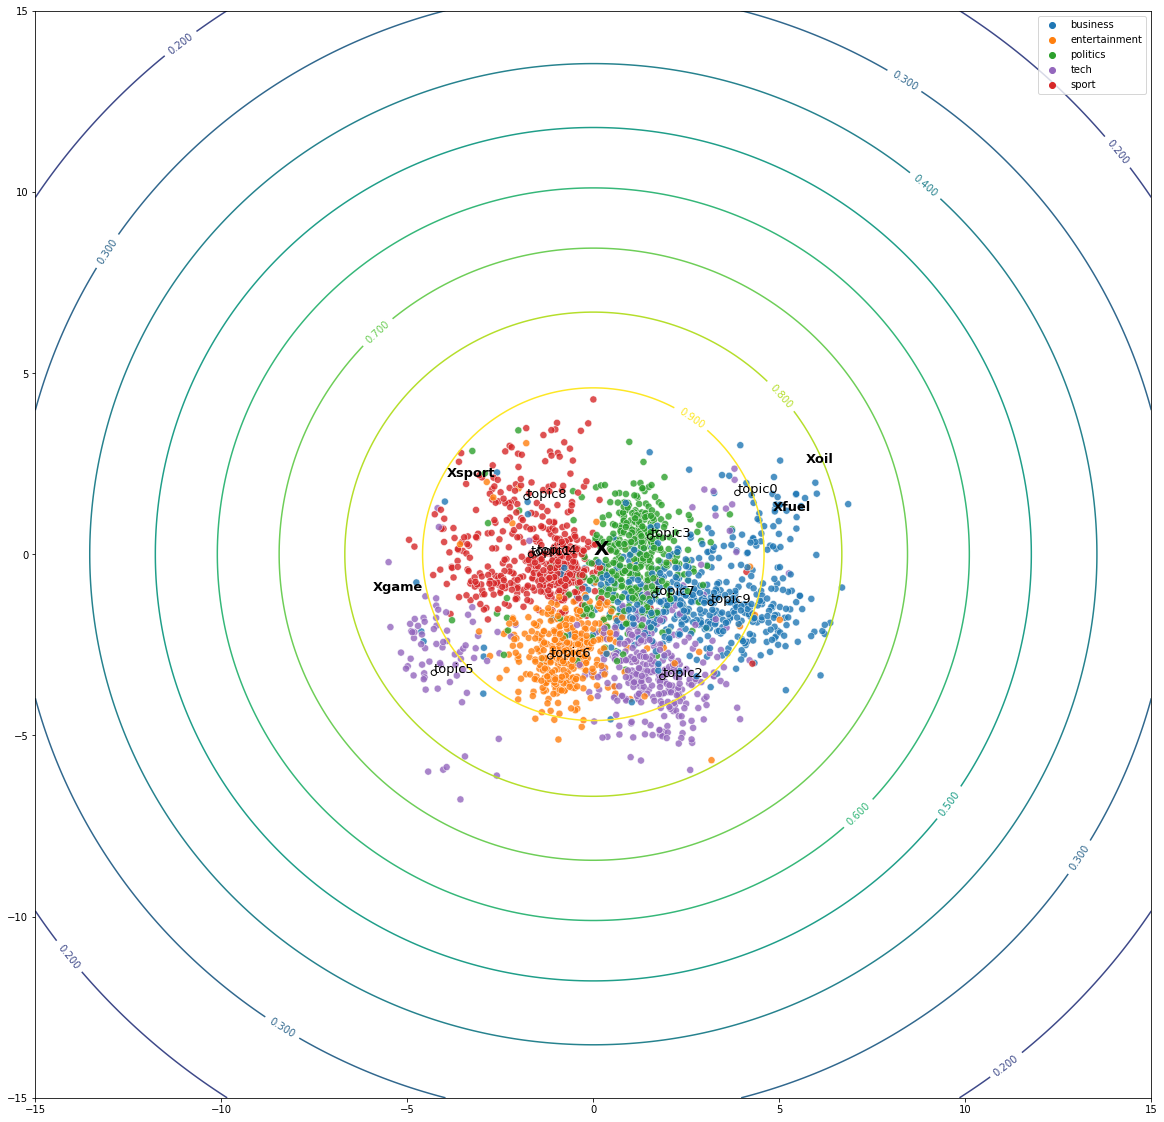

In [ ]:
plot_fig(x_list, labels_list, zphi,ir_query_center.T,query_words=query_words,hv_qwords=True,
         keywords=keyword_vis_labels,lim =15,contour='yes')

In [ ]:
#@title label_dict
topk=200
sorted_docs, sorted_idxs = torch.sort(normalized_all_rscores,descending=True)
topk_DESM_idxs = sorted_idxs[:topk].numpy()
relv_idxs = np.asarray([np.where(doc_ids == topk_DESM_idxs[i])[0][0] for i in range(len(topk_DESM_idxs)) ])

topk_desm_x = x_list[relv_idxs]
topk_desm_x_label = np.array(labels_list)[relv_idxs]

# all_key_doc_vis = []
# for k in keywords:
#   all_key_doc_vis.extend(doc_contains_keyidx[k])
# doc_ids_doc_Conkey =np.asarray([np.where(doc_ids == i)[0][0] for i in all_key_doc_vis])


label_colors_dict = {}
all_labels = list(set(labels_list))
for l in range(len(all_labels)):
  label_colors_dict[all_labels[l]] = 'C'+str(l)
label_colors = np.array([label_colors_dict[k] for k in labels_list])

In [ ]:
# plot_fig_desm_doConKey(topk_desm_x, topk_desm_x_label,x_list[doc_ids_doc_Conkey], labels_list[doc_ids_doc_Conkey], zphi,query_center,query_words=query_words,
#          keywords=keyword_vis_labels,C1=label_colors[relv_idxs],C2=label_colors[doc_ids_doc_Conkey],lim =20,contour='yes')

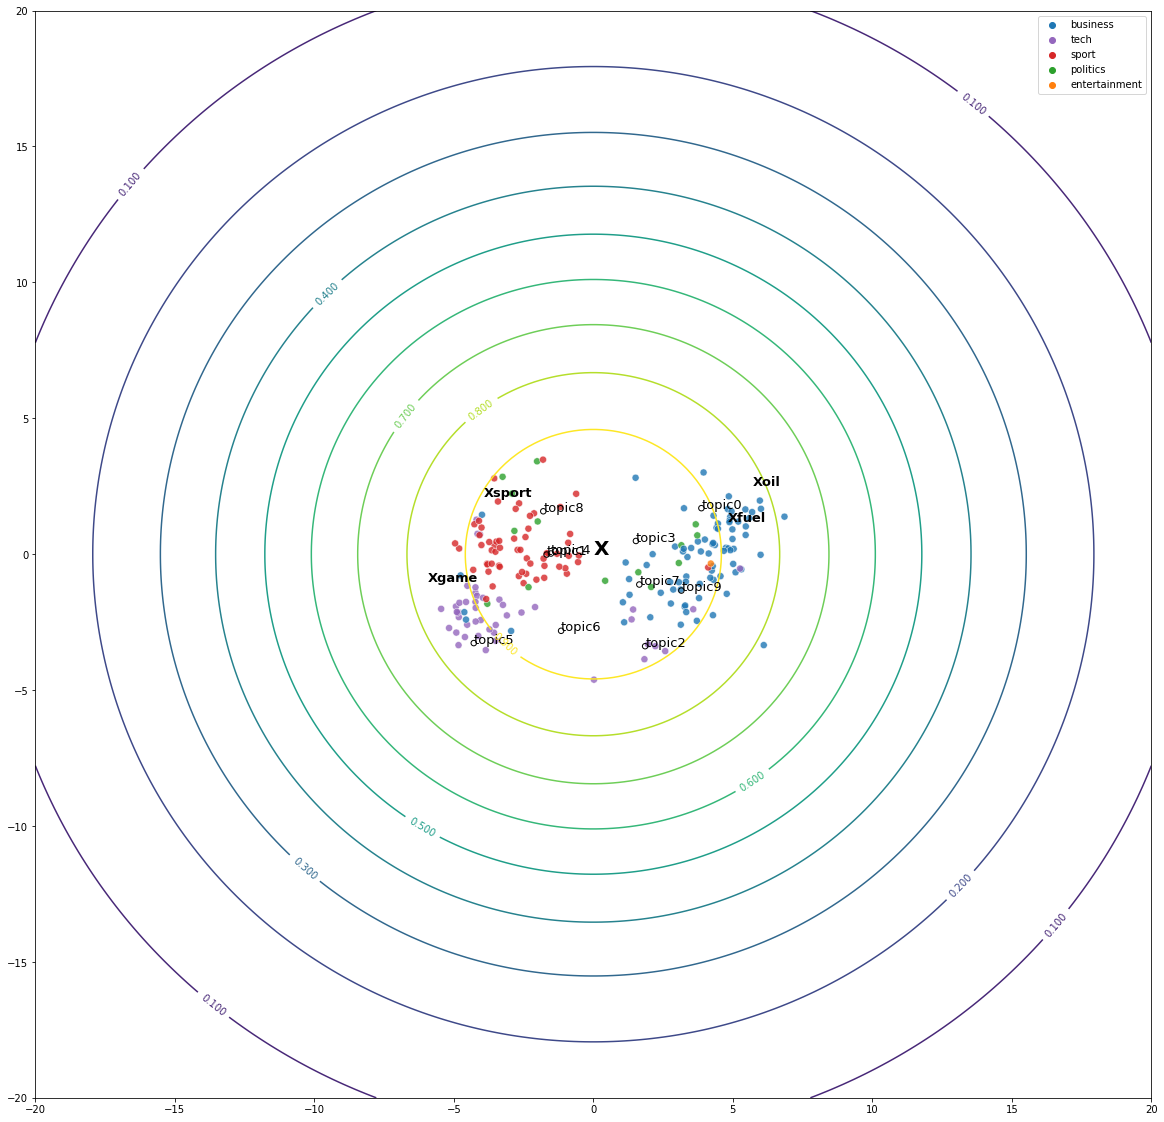

In [ ]:
plot_fig(topk_desm_x, topk_desm_x_label, zphi,ir_query_center.T,query_words=query_words,hv_qwords=True,
         keywords=keyword_vis_labels,lim =20,contour='yes')

In [ ]:
cal_knn(x_list, labels_list)

[0.8345323741007195,
 0.8210431654676259,
 0.8178956834532374,
 0.8129496402877698,
 0.8093525179856115]

In [ ]:
FoTo_topics = get_topwords(beta,id_vocab,topwords=20)

In [ ]:
STOP!!

SyntaxError: ignored

# **WTM**

### Model

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

array([1310])

In [ ]:
##@title Model 7.2 (draw word if)

num_topic =20
bs = 256
drop_rate = 0.2
epochs = 1000

mu_div=100.0
sig = 100.0

smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()


def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.query_center = nn.Parameter(torch.zeros(2,1))
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_, input_keywords_as_docs,count):
        if(count==0):
          input_ = torch.cat((input_,input_keywords_as_docs),0)
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, input_keywords_as_docs,count, posterior_mean, posterior_var, prior_var):
        if(count==0):
          input_ = torch.cat((input_,input_keywords_as_docs),0)
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_theta(self):

      N, *_ = self.z.size()
      zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
      # zx = self.z.view(N, 1, self.num_coordinate)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      doc_topic_size = (N, self.out_features, self.in_features) # NxTx2

      x = zx.expand(doc_topic_size)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

      d_doc_topic = (x-c).pow(2).sum(-1)

      distances_doc_topic = self.basis_func(d_doc_topic)

      theta = torch.exp(distances_doc_topic - torch.logsumexp(distances_doc_topic, dim=-1, keepdim=True))
      return theta ,zx, zc, N


    def decode(self):
      theta, zx, zc,N = self.get_theta()

      mu1 = F.relu((self.mu1_fc(zc)))                           # topic mapping
      mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z = self.mu_fc(mu2)

      self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T + self.beta_bias,dim=-1)
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

      recon_v_relv = torch.mm(theta,self.beta)

      return recon_v_relv, zx,zc, theta

    def forward(self, input_,relevant_scores,cosine_score,input_keywords_as_docs,count,compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_, input_keywords_as_docs,count)
        z = self.take_sample(input_,input_keywords_as_docs,count, posterior_mean, posterior_var, self.variance_x)
        self.cosine_score = cosine_score
        self.z = z
        recon_v_relv, zx,zphi, theta = self.decode()

        if compute_loss:
            return recon_v_relv,zx, self.loss(input_,input_keywords_as_docs,count, recon_v_relv, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx)
        else: return z, recon_v_relv, zx,zphi, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_,input_keywords_as_docs,count, recon_v, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx):

        if(count==0):
          input_ = torch.cat((input_,input_keywords_as_docs),0)

        N = posterior_mean.shape[0]

        NL1 = - (input_ * (recon_v+1e-20).log()).sum(-1)
        NL1 = NL1.sum()

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

        # NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
        NL2 = toT(0.0)
        NL = NL1 + NL2

        loss = NL+ KLD
        return loss/N, NL,NL1,NL2, KLD

###**Train Model**

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords_d = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords_d,emb_size,num_keyword, "gaussian") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter_d.to(device)
norm_cos_score = val.to(device)

for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0
    count = 0
    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        input_keywords_as_docs = torch.from_numpy(keywords_as_docs).float().to(device)
        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        labels = train_label[batch_ndx]
        if(count==0):
          labels = np.concatenate((labels, ["keywords" for i in range(input_keywords_as_docs.shape[0])]), axis=0)
        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,relv_scores,norm_cos_score,input_keywords_as_docs,count,compute_loss=True)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()
        count += 1
    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch, loss_KLD))

    # ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()
    # # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # # query_words = (model.keyword_coords).data.cpu().numpy()
    # keyword_vis_labels = get_keywords(d_data)
    # query_words = np.array(len(keywords)*[[0,0]])
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

Epoch -> 0 , loss -> 1052.132209777832
recon_loss==> 257539.38671875 || NL1==> 257539.38671875 || NL2==> 0.0 || KLD==> 3445.9774780273438
Epoch -> 10 , loss -> 975.707649230957
recon_loss==> 239419.4609375 || NL1==> 239419.4609375 || NL2==> 0.0 || KLD==> 2386.603286743164
Epoch -> 20 , loss -> 962.6737976074219
recon_loss==> 236553.873046875 || NL1==> 236553.873046875 || NL2==> 0.0 || KLD==> 2022.4468383789062
Epoch -> 30 , loss -> 953.9054718017578
recon_loss==> 234362.865234375 || NL1==> 234362.865234375 || NL2==> 0.0 || KLD==> 2030.401382446289
Epoch -> 40 , loss -> 946.0102615356445
recon_loss==> 232184.400390625 || NL1==> 232184.400390625 || NL2==> 0.0 || KLD==> 2256.2400970458984
Epoch -> 50 , loss -> 938.9847106933594
recon_loss==> 230141.76953125 || NL1==> 230141.76953125 || NL2==> 0.0 || KLD==> 2564.163864135742
Epoch -> 60 , loss -> 931.1848907470703
recon_loss==> 227892.03125 || NL1==> 227892.03125 || NL2==> 0.0 || KLD==> 2928.079086303711
Epoch -> 70 , loss -> 924.663131713

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()
x_list = []
labels_list = []
doc_ids = []
docs_rscore = []
count = 0
with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        input_keywords_as_docs = torch.from_numpy(keywords_as_docs).float().to(device)

        labels = train_label[batch_ndx]
        if(count==0):
          labels = np.concatenate((labels, ["keywords" for i in range(input_keywords_as_docs.shape[0])]), axis=0)
        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        z, recon_v, zx, zphi, zx_phi = model(input_w, relv_scores,norm_cos_score, input_keywords_as_docs, count, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        if(count==0): print(zx[-2:,:])
        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])
        x_list.extend(zx)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))
        count += 1
    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)
    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)

    beta = model.get_beta().data.cpu().numpy()
    wtm_beta = beta
    zphi = zphi.data.cpu().numpy()

    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.query_center.data.cpu().numpy()

[[0.6177656 8.33473  ]
 [1.6876835 9.1621475]]


In [ ]:
model.mu_z

tensor([[-1.6122,  0.2174, -0.4772,  ..., -0.1721, -0.4816,  0.0258],
        [-1.6017, -0.9882,  1.3448,  ..., -0.3341, -0.0947, -0.8972],
        [ 0.5712,  1.6959,  0.3651,  ...,  0.1278,  0.1607, -0.1632],
        ...,
        [ 0.4769, -0.9343,  0.8616,  ...,  1.8779, -1.1503, -4.1759],
        [ 0.9108, -0.0615,  0.4051,  ...,  1.3512, -0.0194, -1.9936],
        [ 0.4887,  0.1571,  0.8619,  ...,  0.3981,  0.2076, -0.1992]],
       device='cuda:0')

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

Jaccard sim b/w topics 2 and 3 is :  0.05263157894736842


,appears
firm,5
year,5
win,4
england,3
wale,3


In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

Cosine similarity b/w topic embeddings w score >=  0.9  | Count -  0


In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
# @title Most Co-occuring Bigrams and Most similar words
nlargestVal =  20#@param {type:"integer"}

text_data = [d.split(' ') for d in data_preprocessed]
data = list(itertools.chain.from_iterable(text_data))
matrix, vocab_index = generate_co_occurrence_matrix(data)

data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

bigram_coocurring_word_list = []
most_similar_word_list = []

print("~~~~Most co-occuring bigrams~~~~\n")
for k in keywords:
  bigram_coocurring_word = np.array(data_matrix.nlargest(nlargestVal, k, keep='first').index)
  bigram_coocurring_word_list.extend(bigram_coocurring_word)
  s = data_matrix[k][bigram_coocurring_word]
  bigram_word_cooccurance = list(zip(s,s.index))
  print(bigram_word_cooccurance)
  print(">> ",k," : ",bigram_coocurring_word,'\n')
print('\n----------------------------------\n')
print("~~~~Most similar words~~~~\n")
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  most_similar = np.array(word_list)[np.array(i)][:nlargestVal]
  most_similar_word_list.extend(most_similar)
  print(">> ",keywords[k]," : ",most_similar,'\n')
print('\n----------------------------------\n')
##### Common words #####

print("Common Words between top ",nlargestVal," co-occuring and similar word list for all keywords:- ")
set(bigram_coocurring_word_list).intersection(set(most_similar_word_list))

~~~~Most co-occuring bigrams~~~~

[(3.0, 'website'), (2.0, 'bbc'), (1.0, 'utility'), (1.0, 'jones'), (1.0, 'game'), (1.0, 'reflects'), (1.0, 'tony'), (1.0, 'betting'), (1.0, 'council'), (1.0, 'car'), (1.0, 'hit'), (1.0, 'interactive'), (1.0, 'lesson'), (1.0, 'holmes'), (1.0, 'return'), (1.0, 'understands'), (1.0, 'priority'), (1.0, 'unveils'), (1.0, 'minister'), (1.0, 'break')]
>>  sport  :  ['website' 'bbc' 'utility' 'jones' 'game' 'reflects' 'tony' 'betting'
 'council' 'car' 'hit' 'interactive' 'lesson' 'holmes' 'return'
 'understands' 'priority' 'unveils' 'minister' 'break'] 

[(7.0, 'console'), (6.0, 'maker'), (5.0, 'firm'), (4.0, 'market'), (3.0, 'win'), (2.0, 'nation'), (2.0, 'ireland'), (2.0, 'age'), (2.0, 'played'), (2.0, 'ceremony'), (2.0, 'mobile'), (2.0, 'award'), (2.0, 'time'), (1.0, 'lover'), (1.0, 'transplanted'), (1.0, 'gearing'), (1.0, 'england'), (1.0, 'unbeaten'), (1.0, 'elvis'), (1.0, 'best')]
>>  game  :  ['console' 'maker' 'firm' 'market' 'win' 'nation' 'ireland' '

{'exploration', 'game', 'gas', 'mining', 'oil', 'pipeline', 'played', 'win'}

In [ ]:
colored_print_Topics(topwords=20, beta=wtm_beta)
print(get_keywords(d_data)) #, which_focus,threshold_model

------------------------------
0: england  nation  open ireland  final win  wale cup france australian victory saturday italy coach  scotland dubai injury defeat second davis 
1: plan minister  terror government law wale pension ban england  police suspect strike lord allow foreign child hunting court secretary guantanamo 
2: plan budget brown government call  tax  economic election minister  iraq blair aid economy cut boost  lord country gordon bush tony  
3: firm  china bank share oil  market  cut job company  government deal  report giant  state life stock year foreign scandal cost  
4: game  mobile  sony apple phone player  console  playstation video medium music sale  time  dvd mac portable mini  nintendo gamers gadget 
5: award  film year best  oscar win  actor top prize star band won named aviator book brit british berlin festival bbc  
6: net microsoft security virus internet mail web phone firm  search computer user spam warning peer software network window people website  
7:

In [ ]:
# print_Topics(topwords=20)
# print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
# for k in range(len(keywords)):
#   v, i = torch.sort(all_keywords_score[k],descending=True)
#   print(keywords[k]," : ",np.array(word_list)[np.array(i)][:20])

In [ ]:
keyword_vis_labels = len(get_keywords(d_data))*['']
query_words = np.array(len(keywords)*[[0,0]])

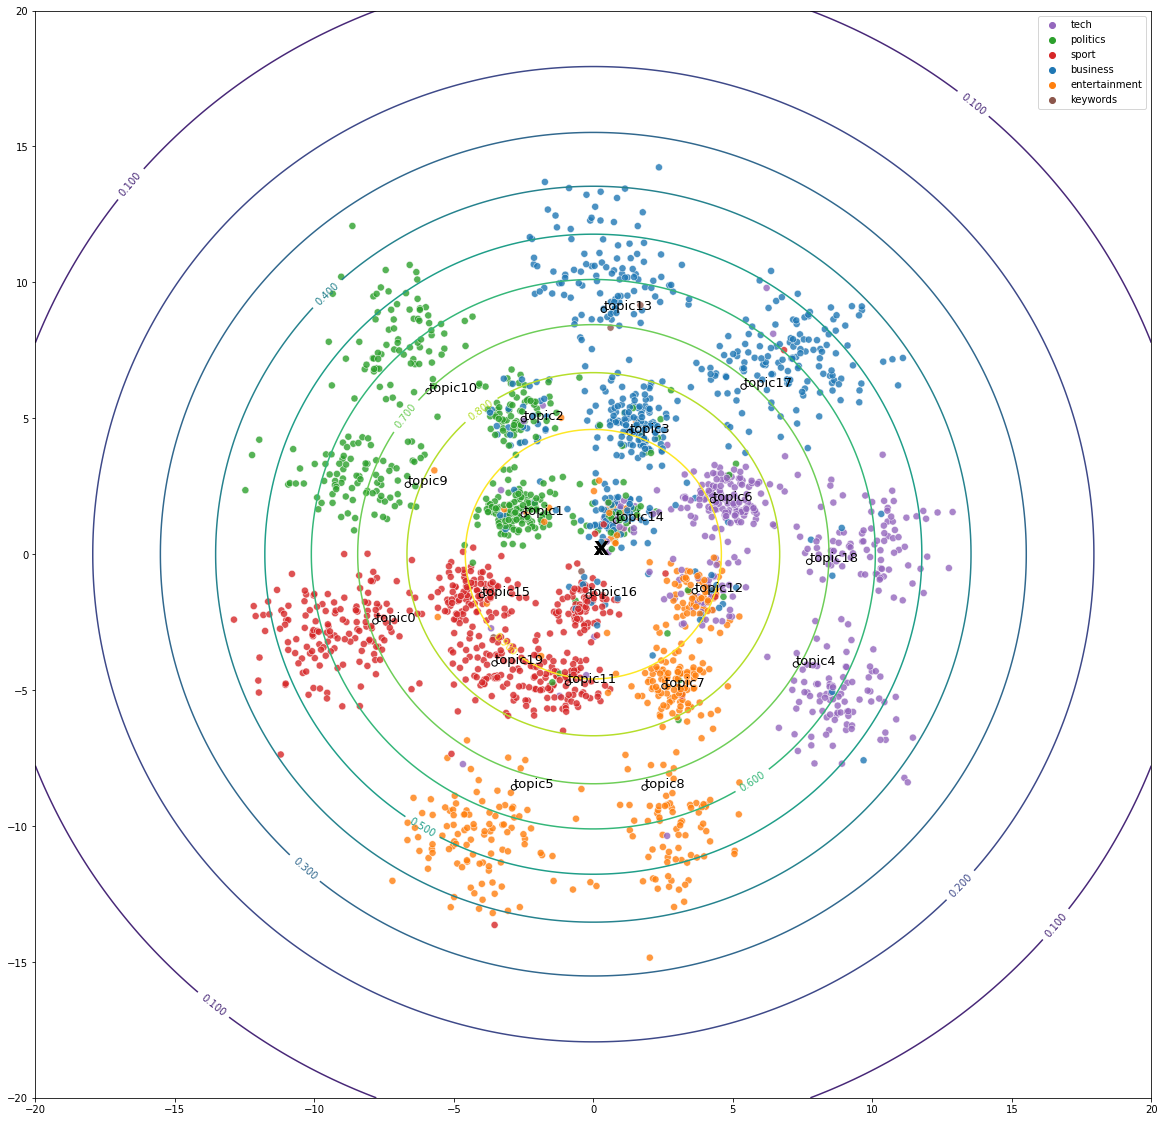

In [ ]:
plot_fig(x_list, labels_list, zphi,query_center,query_words=query_words,hv_qwords=True,
         keywords=keyword_vis_labels,lim =20,contour='yes')

In [ ]:
#@title label_dict
topk=200
sorted_docs, sorted_idxs = torch.sort(normalized_all_rscores,descending=True)
topk_DESM_idxs = sorted_idxs[:topk].numpy()
relv_idxs = np.asarray([np.where(doc_ids == topk_DESM_idxs[i])[0][0] for i in range(len(topk_DESM_idxs)) ])

topk_desm_x = x_list[relv_idxs]
topk_desm_x_label = np.array(labels_list)[relv_idxs]

# all_key_doc_vis = []
# for k in keywords:
#   all_key_doc_vis.extend(doc_contains_keyidx[k])
# doc_ids_doc_Conkey =np.asarray([np.where(doc_ids == i)[0][0] for i in all_key_doc_vis])


label_colors_dict = {}
all_labels = list(set(labels_list))
for l in range(len(all_labels)):
  label_colors_dict[all_labels[l]] = 'C'+str(l)
label_colors = np.array([label_colors_dict[k] for k in labels_list])

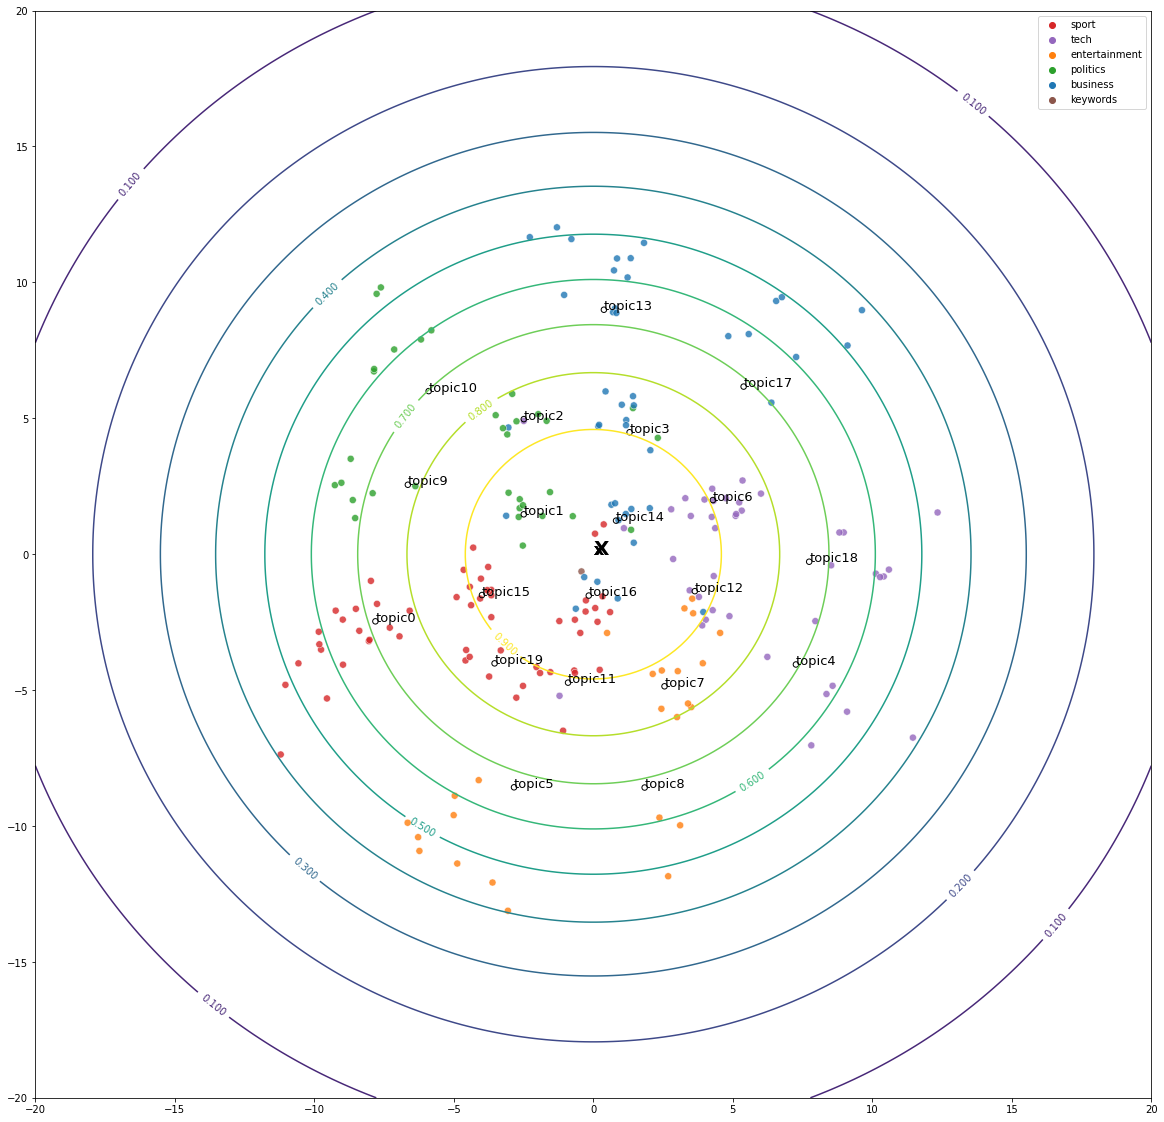

In [ ]:
plot_fig(topk_desm_x, topk_desm_x_label, zphi,query_center,query_words=query_words,hv_qwords=True,
         keywords=keyword_vis_labels,lim =20,contour='yes')

In [ ]:
cal_knn(x_list, labels_list)

[0.8976660682226212,
 0.8918312387791741,
 0.8891382405745063,
 0.8886894075403949,
 0.8873429084380611]

In [ ]:
WTM_topics = get_topwords(beta,id_vocab,topwords=20)

# Sum Cosine Metric

In [ ]:
import plotly.express as px
def plot_relv_topwords(keywords,np_topics_wordsScores):
  for i in range(len(keywords)):
    fig = px.histogram(pd.DataFrame(np_topics_wordsScores[i],columns=['scores']), x="scores")
    print(keywords[i])
    fig.show()
# print("Spike Slab Filter (top # relv words that represents documents):",spikeSlab_filter,"\n\n")

In [ ]:
def keyw_sum_median_mean(np_topics_wordsScores):
   return keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
# PLSV_topics
# WTM_topics
# FoTo_topics


def get_cosine_sum_topics(all_topics,m_beta,topwords_cos_sum):
  all_topics = get_topwords(m_beta,id_vocab,topwords=20)
  topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
  np_topics_wordsScores_l = []
  for topics in topics_wordlist:
    topics_wordtensors = get_embedding_tensor(topics,embeddings)
    topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,topics,cos_sim)
    np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
    np_topics_wordsScores_l.append(np_topics_wordsScores)
  return np_topics_wordsScores_l

np_topics_wordsScores_WTM = get_cosine_sum_topics(WTM_topics,wtm_beta,topwords_cos_sum=20)
np_topics_wordsScores_FoTo = get_cosine_sum_topics(FoTo_topics,foto_beta,topwords_cos_sum=20)

sum_max_wtm = []
sum_max_foto = []

for np_topics_wordsScores in np_topics_wordsScores_WTM:
  _,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores)
  sum_max_wtm.append(sum_max)
  print(sum_max)

print('\n\nFoto\n\n')
for np_topics_wordsScores in np_topics_wordsScores_FoTo:
  _,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores)
  sum_max_foto.append(sum_max)
  print(sum_max)

3.936636209487915
2.768136739730835
3.498791217803955
4.494316577911377
4.692156791687012
2.9501664638519287
2.352179765701294
2.67942476272583
2.5498437881469727
2.3241169452667236
2.507126569747925
4.1348161697387695
3.9888057708740234
3.5113234519958496
2.5799946784973145
4.117527961730957
4.49826192855835
4.56538200378418
2.886180877685547
4.352035045623779


Foto


7.370537281036377
5.707124710083008
2.7139768600463867
2.5196776390075684
2.3992366790771484
5.879138946533203
2.8319554328918457
3.3471639156341553
6.394720077514648
3.550386428833008


In [ ]:
i=0
for smax_wtm,smax_foto in zip(sum_max_wtm,sum_max_foto):
  if smax_foto>smax_wtm:
    print('Foto topic',i,':',smax_foto)
  else:
    print('WTM topic',i,':',smax_wtm)
  i=i+1

Foto topic 0 : 7.370537281036377
Foto topic 1 : 5.707124710083008
WTM topic 2 : 3.498791217803955
WTM topic 3 : 4.494316577911377
WTM topic 4 : 4.692156791687012
Foto topic 5 : 5.879138946533203
Foto topic 6 : 2.8319554328918457
Foto topic 7 : 3.3471639156341553
Foto topic 8 : 6.394720077514648
Foto topic 9 : 3.550386428833008


In [ ]:
np.sort(sum_max_foto)[-5:],np.argsort(sum_max_foto)[-5:]

(array([3.55038643, 5.70712471, 5.87913895, 6.39472008, 7.37053728]),
 array([9, 1, 5, 8, 0]))

In [ ]:
np.sort(sum_max_wtm)[-5:],np.argsort(sum_max_wtm)[-5:]

(array([4.35203505, 4.49431658, 4.49826193, 4.565382  , 4.69215679]),
 array([19,  3, 16, 17,  4]))

In [ ]:
a = [i for i in range(10)]
plot_relative_diff(a,sum_max_foto,sum_max_wtm,"WTM","sum_V_topics","sum_score","topics")

In [ ]:
STOP!!

SyntaxError: ignored

In [ ]:
def get_cosine_sum_topics(all_topics,m_beta,topwords_cos_sum):
  all_topics = get_topwords(m_beta,id_vocab,topwords=topwords_cos_sum)
  topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
  np_flatten_topics_wordlist = np.array(flatten_list(topics_wordlist))
  topics_wordtensors = get_embedding_tensor(np_flatten_topics_wordlist,embeddings)
  topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cos_sim)
  np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
  return np_topics_wordsScores


np_topics_wordsScores_WTM = get_cosine_sum_topics(WTM_topics,wtm_beta,topwords_cos_sum=20)
np_topics_wordsScores_FoTo = get_cosine_sum_topics(FoTo_topics,foto_beta,topwords_cos_sum=20)
# np_topics_wordsScores_PLSV = get_cosine_sum_topics(PLSV_topics)
# np_topics_wordsScores_FoTo = get_cosine_sum_topics(topwords_cos_sum=10)
# np_topics_wordsScores_WTM = min_max_norm_1(np_topics_wordsScores_WTM)

# plot_relv_topwords(keywords,np_topics_wordsScores_FoTo)
_,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores_FoTo)
print(sum_max)
_,sum_max,_,_ = keyw_sum_median_mean(np_topics_wordsScores_WTM)
print(sum_max)

42.71391677856445
69.3872299194336


In [ ]:
a = [i for i in range(10,40,10)]
cos_sum_max_foto = []
cos_sum_max_wtm = []
for i in a:
  np_topics_wordsScores_FoTo = get_cosine_sum_topics(FoTo_topics,foto_beta,topwords_cos_sum=i)
  np_topics_wordsScores_WTM = get_cosine_sum_topics(WTM_topics,wtm_beta,topwords_cos_sum=i)
  _,sum_max_foto,_,_ = keyw_sum_median_mean(np_topics_wordsScores_FoTo)
  _,sum_max_wtm,_,_ = keyw_sum_median_mean(np_topics_wordsScores_WTM)
  cos_sum_max_foto.append(sum_max_foto)
  cos_sum_max_wtm.append(sum_max_wtm)

In [ ]:
plot_relative_diff(a,cos_sum_max_foto,cos_sum_max_wtm,"WTM","cos_sum_V_topwords","cos_sum_score","topwords")

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores_FoTo)

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores_WTM)

In [ ]:
STOP!!

# *Archived Models*


## **FoTo - (WTM + Dual Center Coord ContraVis)**

### Model

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
# threshold_focus_two_doc_coord = torch.median(keywords_max_score)
threshold_focus_two_doc_coord = 0.5
# a = keywords_max_score
a = list_of_tensors_to_tensor(all_keywords_score).mean(0)
q = torch.tensor([threshold_focus_two_doc_coord])
q_v = torch.quantile(a, q, dim=0, keepdim=True)
filter = torch.zeros(num_input)
for i in range(num_input):
  if(a[i]>q_v):
    filter[i] = 1
filter.sum(-1)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

In [ ]:
num_topic =10
bs = 256
drop_rate = 0.2
epochs = 1000

mu_div=100.0
sig = 100.0

smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()


def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic

        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        # self.query_center = nn.Parameter(torch.Tensor(1, self.in_features))
        self.query_center_relv = nn.Parameter(torch.Tensor(1, self.in_features))
        self.query_center_irrelv = nn.Parameter(torch.Tensor(1, self.in_features))
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_ir_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)
        nn.init.normal_(self.query_center_relv, 0, 0.01)
        nn.init.normal_(self.query_center_irrelv, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn(self.mean_fc(en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_theta(self):

      N, *_ = self.x.size()

      zx = self.decoder_x_bn(self.x).view(N, 1, self.num_coordinate) # Nx1x2
      # zx = self.x.view(N, 1, self.num_coordinate)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      c = zc.view(1, self.num_topic, self.num_coordinate).expand(N,self.num_topic,self.num_coordinate)

      x_c = zx.expand(N,self.num_topic,self.num_coordinate)
      d_doc_topic = (x_c-c).pow(2).sum(-1)

      distances_doc_topic = self.basis_func(d_doc_topic)
      # theta = torch.exp(distances_doc_topic - torch.logsumexp(distances_doc_topic, dim=-1, keepdim=True))

      ####### relevant doc-topic matrix (theta_r) [p(z|x,q)]
      topic_q_size = (self.num_topic, 2, self.in_features) # TxQx2
      doc_q_size = (N, 2, self.in_features) # NxQx2

      self.q = torch.cat((self.query_center_relv,self.query_center_irrelv),dim=0)


####  doc_q_softmax  #######

      x_q = zx.expand(doc_q_size)
      q_doc = self.q.unsqueeze(0).expand(doc_q_size)
      doc_q_dist = (x_q-q_doc).pow(2).sum(-1)
      distances_q_doc = self.basis_func(doc_q_dist)
      self.doc_q_softmax = torch.exp(distances_q_doc - torch.logsumexp(distances_q_doc, dim=-1, keepdim=True))

#### q_dep_theta ####

      c_q = self.topics.unsqueeze(1).expand(topic_q_size) # TxQx2
      q_topic = self.q.unsqueeze(0).expand(topic_q_size)

      d_q_topic = (c_q-q_topic).pow(2).sum(-1)

      distances_q_topic = self.basis_func(d_q_topic)

      add_size = (N,self.num_topic,2)
      distances_doc_topic_expanded = distances_doc_topic.unsqueeze(-1).expand(add_size)
      distances_q_topic_expanded = distances_q_topic.unsqueeze(0).expand(add_size)

      q_dep_theta = torch.exp( (distances_doc_topic_expanded + distances_q_topic_expanded) - torch.logsumexp((distances_doc_topic_expanded + distances_q_topic_expanded), dim=1, keepdim=True))#    NxTxQ


      return q_dep_theta, zx, zc, N


    def decode(self):
      q_dep_theta, zx, zc,N = self.get_theta()

      mu1 = F.relu((self.mu1_fc(zc)))                           # topic mapping
      mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z = self.mu_fc(mu2)

      # cos_ranking = torch.max(self.cosine_score,0).values
      cos_ranking = self.cosine_score.mean(0)


      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T * cos_ranking,dim=-1)
      self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

      # self.beta_irrelv = F.softmax(self.decoder_bn_ir(torch.mm(self.mu_z_irrelv,self.embedding_words.T).T).T,dim=-1)
      # self.beta = torch.cat((self.beta_relv,self.beta_irrelv),dim=0)

      # recon_v_relv = torch.mm(theta_r,self.beta_relv)
      # recon_v_irrelv = torch.mm(theta_ir,self.beta_irrelv)

      theta = torch.matmul(q_dep_theta,self.doc_q_softmax.unsqueeze(-1)).squeeze(-1) # NxTxK x  NxKx1 --> (take sum across k) NxTx1 --> squeeze --> NxT
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T),dim=-1)
      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T,dim=-1)

      recon_v = torch.mm(theta,self.beta)
      return recon_v, zx,zc, theta

    def forward(self, input_,relevant_scores,cosine_score,filter,compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)

        x = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)
        self.cosine_score = cosine_score
        self.x = x

        recon_v, zx, zphi, theta = self.decode()

        if compute_loss:
            return recon_v, zx, self.loss(input_, recon_v, filter,posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx)
        else: return x, recon_v , zx, zphi, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v, filter, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx):
        N = posterior_mean.shape[0]
#  * self.cosine_score.mean(0)
        NL1 = - ((input_ * (recon_v +1e-20).log())).sum(-1)
        NL1 = NL1.sum()

        which_center = torch.cat((filter.unsqueeze(0) , (1-filter.unsqueeze(0))))

        p_q = torch.mm(self.doc_q_softmax,which_center)

        NL2 = - ((input_ * (p_q+smoothen).log())).sum(-1)
        NL2 = NL2.sum()

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

        # NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
        NL2 = toT(0.0)
        NL = NL1 + NL2 #+ (- 100.0 * (self.query_center_relv - self.query_center_irrelv).pow(2).sum(-1))

        loss = NL+ KLD
        return loss/N, NL,NL1,NL2, KLD

###**Train Model**

In [ ]:
def torch_round_to_ndigits(arr,n_digits):
  return torch.round(arr * 10**n_digits) / (10**n_digits)

word_count_tensor = torch.tensor(train_vec,dtype=torch.float32)
doc_embedding = get_unit_len_embeddings(torch.mm(word_count_tensor , embedding_tensor_sorted_alp))
doc_key_cosine = get_cosine_score(doc_embedding,embedding_tensor_keywords,0.5)
r_score = torch_round_to_ndigits(doc_key_cosine.sum(-1)/len(keywords),1)

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords_d = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords_d,emb_size,num_keyword, "inverse_quadratic") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter.to(device)
norm_cos_score = val.to(device)

for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0

    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        labels = train_label[batch_ndx]

        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,relv_scores,norm_cos_score,word_filter,compute_loss=True)
        # zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy() ## Vis while training

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()

    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {} , KLD-> {}'.format(epoch,loss_epoch,loss_KLD))
        print('recon_loss==> {} || NL1==> {} || NL2==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch))

    ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()
    # # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # # query_words = (model.keyword_coords).data.cpu().numpy()
    # keyword_vis_labels = get_keywords(d_data)
    # query_words = np.array(len(keywords)*[[0,0]])
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()

x_list = []

labels_list = []
doc_ids = []
docs_rscore = []

with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        z, recon_v, zx, zphi, zx_phi = model(input_w, relv_scores,norm_cos_score,word_filter, compute_loss=False)

        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])

        x_list.extend(zx)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)

    # labels_list = list(labels_list)*2
    # relv_x_list = np.array(relv_x_list)
    # irrelv_x_list = np.array(irrelv_x_list)

    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)

    beta = model.get_beta().data.cpu().numpy()
    zphi = zphi.data.cpu().numpy()

    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.q.data.cpu().numpy()

In [ ]:
model.mu_z

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
# @title Most Co-occuring Bigrams and Most similar words
nlargestVal =  20#@param {type:"integer"}

text_data = [d.split(' ') for d in data_preprocessed]
data = list(itertools.chain.from_iterable(text_data))
matrix, vocab_index = generate_co_occurrence_matrix(data)

data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)

bigram_coocurring_word_list = []
most_similar_word_list = []

print("~~~~Most co-occuring bigrams~~~~\n")
for k in keywords:
  bigram_coocurring_word = np.array(data_matrix.nlargest(nlargestVal, k, keep='first').index)
  bigram_coocurring_word_list.extend(bigram_coocurring_word)
  s = data_matrix[k][bigram_coocurring_word]
  bigram_word_cooccurance = list(zip(s,s.index))
  print(bigram_word_cooccurance)
  print(">> ",k," : ",bigram_coocurring_word,'\n')
print('\n----------------------------------\n')
print("~~~~Most similar words~~~~\n")
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  most_similar = np.array(word_list)[np.array(i)][:nlargestVal]
  most_similar_word_list.extend(most_similar)
  print(">> ",keywords[k]," : ",most_similar,'\n')
print('\n----------------------------------\n')
##### Common words #####

print("Common Words between top ",nlargestVal," co-occuring and similar word list for all keywords:- ")
set(bigram_coocurring_word_list).intersection(set(most_similar_word_list))

In [ ]:
colored_print_Topics(topwords=20)
print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
keyword_vis_labels = len(get_keywords(d_data))*['']
query_words = np.array(len(keywords)*[[0,0]])

In [ ]:
def plot_fig_two_center(zx, labels_list, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    label_colors_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=label_colors_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    ax.text(query_center[0][0],query_center[0][1], 'X' ,c='red',weight='bold') # relv
    ax.text(query_center[1][0],query_center[1][1], 'X' ,c='black',weight='bold')
    # ax.text(0,0, 'X' ,c='black')
    # for i in range(len(query_words)):
    #   if (i==len(query_words)-1):
    #     ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
    #   else:
    #     ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))


In [ ]:
plot_fig_two_center(x_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =20,contour='yes')

In [ ]:
# FoTo_topics = get_topwords(beta,id_vocab,topwords=topwords)

In [ ]:
 STOP!!

## **FoTo - (WTM + Dual DOC Coord)**

### Model

In [ ]:
threshold_focus_two_doc_coord = torch.median(keywords_max_score)
filter = torch.zeros(num_input)
for i in range(num_input):
  if(keywords_max_score[i]>threshold_focus_two_doc_coord):
    filter[i] = 1

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

In [ ]:
num_topic =10
bs = 256
drop_rate = 0.2
epochs = 1000

mu_div=100.0
sig = 100.0

smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()


def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0
        self.mu_z_relv = 0
        self.mu_z_irrelv = 0

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic

        self.num_relv_topics = int(0.7*self.num_topic)
        self.num_irrelv_topics = self.num_topic - self.num_relv_topics

        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.query_center = nn.Parameter(torch.Tensor(1, self.in_features))
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

        self.decoder_bn_r = nn.BatchNorm1d(self.num_relv_topics) #
        self.decoder_bn_ir = nn.BatchNorm1d(self.num_irrelv_topics) #

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_ir_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)
        nn.init.normal_(self.query_center, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn(self.mean_fc(en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_theta(self):

      N, *_ = self.x.size()

      zx_relv = self.decoder_x_bn(self.x).view(N, 1, self.num_coordinate) # Nx1xX
      zx_irrelv = self.decoder_x_ir_bn(self.y).view(N, 1, self.num_coordinate) # Nx1xX

      # zx = self.z.view(N, 1, self.num_coordinate)

      doc_relv_topic_size = (N, self.num_relv_topics, self.in_features) # Nx(T_r)x2
      doc_irrelv_topic_size = (N, self.num_irrelv_topics, self.in_features) # Nx(T_ir)x2

      x_r = zx_relv.expand(doc_relv_topic_size)
      x_ir = zx_irrelv.expand(doc_irrelv_topic_size)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      c = zc.view(1, self.num_topics, self.num_coordinate).expand(doc_relv_topic_size)


      # self.relv_topics = zc[:self.num_relv_topics]
      # self.irrelv_topics = zc[self.num_relv_topics:]

      # c_r = self.relv_topics.view(1, self.num_relv_topics, self.num_coordinate).expand(doc_relv_topic_size)
      # c_ir = self.irrelv_topics.view(1, self.num_irrelv_topics, self.num_coordinate).expand(doc_irrelv_topic_size)

      ###### irrelevant doc-topic matrix (theta_ir) [p(z|x)]
      d_doc_irrelv_topic = (x_ir-c_ir).pow(2).sum(-1)

      distances_doc_irrelv_topic = self.basis_func(d_doc_irrelv_topic)
      theta_ir = torch.exp(distances_doc_irrelv_topic - torch.logsumexp(distances_doc_irrelv_topic, dim=-1, keepdim=True))

      ####### relevant doc-topic matrix (theta_r) [p(z|x,q)]
      topic_q_size = (self.num_relv_topics, 1, self.in_features) # Tx1x2
      # doc_q_size = (N,1,self.in_features) # Nx1x2

      c_q = self.relv_topics.unsqueeze(1) # TxQx2
      q_topic = q.unsqueeze(0).expand(topic_q_size).to(device)

      d_doc_relv_topic = (x_r-c_r).pow(2).sum(-1)
      d_q_relv_topic = (c_q-q_topic).pow(2).sum(-1)

      distances_doc_relv_topic = self.basis_func(d_doc_relv_topic)
      distances_q_relv_topic = self.basis_func(d_q_relv_topic)

      add_size = (N,self.num_relv_topics,1)
      distances_doc_relv_topic_expanded = distances_doc_relv_topic.unsqueeze(-1).expand(add_size)
      distances_q_topic_expanded = distances_q_relv_topic.unsqueeze(0).expand(add_size)

      theta_r = torch.exp( (distances_doc_relv_topic_expanded + distances_q_topic_expanded) - torch.logsumexp((distances_doc_relv_topic_expanded + distances_q_topic_expanded), dim=1, keepdim=True)).squeeze(-1)  #    NxTxK

      theta = torch.cat((theta_r,theta_ir),dim=1)
      zx = [zx_relv,zx_irrelv]

      return theta,theta_r,theta_ir, zx, zc, N


    def decode(self):
      theta,theta_r,theta_ir, zx, zc,N = self.get_theta()

      mu1 = F.relu((self.mu1_fc(self.relv_topics)))                           # topic mapping
      mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z_relv = self.mu_fc(mu2)

      mu1 = F.relu((self.mu1_fc(self.irrelv_topics)))                           # topic mapping
      mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z_irrelv = self.mu_fc(mu2)

      self.mu_z = torch.cat((self.mu_z_relv,self.mu_z_irrelv),dim=0)

      cos_ranking =torch.max(self.cosine_score,0).values
      self.beta_relv = F.softmax(self.decoder_bn_r(torch.mm(self.mu_z_relv,self.embedding_words.T).T).T * cos_ranking,dim=-1)
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

      self.beta_irrelv = F.softmax(self.decoder_bn_ir(torch.mm(self.mu_z_irrelv,self.embedding_words.T).T).T,dim=-1)
      self.beta = torch.cat((self.beta_relv,self.beta_irrelv),dim=0)

      recon_v_relv = torch.mm(theta_r,self.beta_relv)
      recon_v_irrelv = torch.mm(theta_ir,self.beta_irrelv)

      # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T,dim=-1)

      # recon_v_relv = torch.mm(theta,self.beta)
      # recon_v_irrelv = toT(0.0)





      return recon_v_relv,recon_v_irrelv, zx,zc, theta

    def forward(self, input_,relevant_scores,cosine_score,filter,compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)

        x = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)
        y = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        self.cosine_score = cosine_score
        self.x = x
        self.y = y

        recon_v_relv,recon_v_irrelv, zx, zphi, theta = self.decode()

        if compute_loss:
            return recon_v_relv,recon_v_irrelv, zx, self.loss(input_, recon_v_relv,recon_v_irrelv,filter,posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx)
        else: return x, recon_v_relv, zx, zphi, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v_relv,recon_v_irrelv,filter, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx):
        N = posterior_mean.shape[0]

        NL1 = - ((input_ * filter * (recon_v_relv+1e-20).log())).sum(-1)
        NL1 = NL1.sum()

        NL2 = - ((input_ * (1-filter) * (recon_v_irrelv+1e-20).log())).sum(-1)
        NL2 = NL2.sum()

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

        # NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
        # NL2 = toT(0.0)
        NL = NL1 + NL2

        loss = NL+ KLD
        return loss/N, NL,NL1,NL2, KLD

###**Train Model**

In [ ]:
def torch_round_to_ndigits(arr,n_digits):
  return torch.round(arr * 10**n_digits) / (10**n_digits)

word_count_tensor = torch.tensor(train_vec,dtype=torch.float32)
doc_embedding = get_unit_len_embeddings(torch.mm(word_count_tensor , embedding_tensor_sorted_alp))
doc_key_cosine = get_cosine_score(doc_embedding,embedding_tensor_keywords,0.5)
r_score = torch_round_to_ndigits(doc_key_cosine.sum(-1)/len(keywords),1)

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords_d = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords_d,emb_size,num_keyword, "inverse_quadratic") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter.to(device)
norm_cos_score = val.to(device)

for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0

    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        labels = train_label[batch_ndx]

        recon_v_relv,recon_v_irrelv, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,relv_scores,norm_cos_score,word_filter,compute_loss=True)
        # zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy() ## Vis while training

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()

    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch, loss_KLD))

    ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()
    # # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # # query_words = (model.keyword_coords).data.cpu().numpy()
    # keyword_vis_labels = get_keywords(d_data)
    # query_words = np.array(len(keywords)*[[0,0]])
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()

x_list = []
irrelv_x_list = []

labels_list = []
doc_ids = []
docs_rscore = []

with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        z, recon_v, zx, zphi, zx_phi = model(input_w, relv_scores,norm_cos_score,word_filter, compute_loss=False)
        relv_x,irrelv_x = zx

        relv_x = relv_x.view(-1, num_coordinate).data.detach().cpu().tolist()
        irrelv_x = irrelv_x.view(-1, num_coordinate).data.detach().cpu().tolist()

        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])

        x_list.extend(relv_x)
        irrelv_x_list.extend(irrelv_x)

        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

    doc_ids = doc_ids.astype(int)

    x_list.extend(irrelv_x_list)
    x_list = np.array(x_list)

    # labels_list = list(labels_list)*2
    # relv_x_list = np.array(relv_x_list)
    # irrelv_x_list = np.array(irrelv_x_list)

    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)

    beta = model.get_beta().data.cpu().numpy()
    zphi = zphi.data.cpu().numpy()

    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.query_center.data.cpu().numpy()

In [ ]:
model.mu_z

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  print(keywords[k]," : ",np.array(word_list)[np.array(i)][:20])

In [ ]:
keyword_vis_labels = len(get_keywords(d_data))*['']
query_words = np.array(len(keywords)*[[0,0]])

In [ ]:
def plot_fig_two_doc_coords(zx, labels_list, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    label_colors_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    half = int(len(zx)/2)
    relv_zx = zx[:half]
    irrelv_zx  =zx[half:]
    sb.scatterplot(ax=ax,x=relv_zx[:,0],y=relv_zx[:,1],hue=labels_list,alpha=1.0,palette=label_colors_dict,marker="x",s=50,edgecolors='black',)
    # sb.scatterplot(ax=ax,x=irrelv_zx[:,0],y=irrelv_zx[:,1],hue=labels_list,alpha=1.0,palette=label_colors_dict,s=50,)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    # ax.text(query_center[0],query_center[1], 'X' ,c='red')
    # ax.text(0,0, 'X' ,c='black')
    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
plot_fig_two_doc_coords(x_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =15,contour='yes')

In [ ]:
# FoTo_topics = get_topwords(beta,id_vocab,topwords=topwords)

In [ ]:
 STOP!!

## **FoTo - DOC MODEL + WTM**

### Model

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

In [ ]:
##@title Model 7.2 (draw word if)

num_topic =10
bs = 256
drop_rate = 0.2
epochs = 1000

mu_div=100.0
sig = 100.0

smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()


def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.query_center = nn.Parameter(torch.zeros(2,1))
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        self.init_parameters()

        # decoder layer
        self.decoder    = nn.Linear(self.num_topic, self.num_input)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)
        self.decoder_kn = nn.BatchNorm1d(self.num_keyword)

        # decoder document
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_theta(self):

      N, *_ = self.z.size()
      zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
      # zx = self.z.view(N, 1, self.num_coordinate)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      doc_topic_size = (N, self.out_features, self.in_features) # NxTx2

      x = zx.expand(doc_topic_size)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

      d_doc_topic = (x-c).pow(2).sum(-1)

      distances_doc_topic = self.basis_func(d_doc_topic)

      theta = torch.exp(distances_doc_topic - torch.logsumexp(distances_doc_topic, dim=-1, keepdim=True))
      return theta ,zx, zc, N


    def decode(self):
      theta, zx, zc,N = self.get_theta()

      mu1 = F.relu((self.mu1_fc(zc)))                           # topic mapping
      mu2 = F.relu(self.en2_drop(self.mu2_fc(mu1)))
      self.mu_z = self.mu_fc(mu2)

      cos_ranking =torch.max(self.cosine_score,0).values
      self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z,self.embedding_words.T).T).T * cos_ranking ,dim=-1)
      # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_ranking,dim=-1)

      recon_v_relv = torch.mm(theta,self.beta)

      return recon_v_relv, zx,zc, theta

    def forward(self, input_,relevant_scores,cosine_score,compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)
        self.cosine_score = cosine_score
        self.z = z
        recon_v_relv, zx,zphi, theta = self.decode()

        if compute_loss:
            return recon_v_relv,zx, self.loss(input_, recon_v_relv, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx)
        else: return z, recon_v_relv, zx,zphi, theta

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v, posterior_mean, posterior_logvar, posterior_var, relevant_scores,zx):
        N = posterior_mean.shape[0]

        NL1 = - (input_ * (recon_v+1e-20).log()).sum(-1)
        NL1 = NL1.sum()

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()

        NL2 = - LogL_NewBeta(zx,relevant_scores).sum()
        # NL2 = toT(0.0)
        NL = NL1 + NL2

        loss = NL+ KLD
        return loss/N, NL,NL1,NL2, KLD

###**Train Model**

In [ ]:
def torch_round_to_ndigits(arr,n_digits):
  return torch.round(arr * 10**n_digits) / (10**n_digits)

word_count_tensor = torch.tensor(train_vec,dtype=torch.float32)
doc_embedding = get_unit_len_embeddings(torch.mm(word_count_tensor , embedding_tensor_sorted_alp))
doc_key_cosine = get_cosine_score(doc_embedding,embedding_tensor_keywords,0.5)
r_score = torch_round_to_ndigits(doc_key_cosine.sum(-1)/len(keywords),1)

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords_d = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords_d,emb_size,num_keyword, "inverse_quadratic") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter.to(device)
norm_cos_score = val.to(device)

for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0

    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        labels = train_label[batch_ndx]

        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,relv_scores,norm_cos_score,compute_loss=True)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()

    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch, loss_KLD))

    ## Vis while training
    zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    query_center = model.query_center.data.cpu().numpy()
    # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # query_words = (model.keyword_coords).data.cpu().numpy()
    keyword_vis_labels = get_keywords(d_data)
    query_words = np.array(len(keywords)*[[0,0]])
    x_coord_train_list = np.array(x_coord_train_list)
    labels_list = np.array(labels_list)
    keyword_vis_labels = get_keywords(d_data)+['dummy']
    if epoch %100 ==0:
      plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =20,contour='yes')

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()
x_list = []
labels_list = []
doc_ids = []
docs_rscore = []

with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        relv_scores = rounded_normalized_all_rscores[batch_ndx].to(device).unsqueeze(-1)
        # relv_scores = r_score[batch_ndx].to(device).unsqueeze(-1)
        z, recon_v, zx, zphi, zx_phi = model(input_w, relv_scores,norm_cos_score, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])
        x_list.extend(zx)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)
    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)

    beta = model.get_beta().data.cpu().numpy()
    zphi = zphi.data.cpu().numpy()

    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.query_center.data.cpu().numpy()

In [ ]:
model.mu_z

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
# ------------------------------
# 0: plan aid government budget chief minister set rule cut tsunami leader public child charge report bill time country court state
# 1: election blair tory party brown tony howard michael gordon attack general campaign liberal minister war secretary voter kennedy george prime
# 2: firm economy year bank profit net price company deal share hit sale oil month china india stock growth bid market
# 3: mobile game computer internet microsoft technology music phone online sony video gadget digital software player industry playstation wireless spam people
# 4: cup coach chelsea club manchester bos england wale liverpool manager football rugby utd wenger league player union madrid captain midfielder
# 5: music top game film movie star fan television song player box cinema news year month release screen video life best
# 6: cup coach chelsea club bos manchester wale england liverpool manager football utd wenger rugby union league player madrid captain midfielder
# 7: tory gordon tony campaign bbc david election general premiership prime wale battle told appeal howard bush supporter michael charles quit
# 8: win ireland england champion open year nation match france victory final injury saturday return tennis scotland round country sprinter championship
# 9: film award star oscar top movie actor best singer chart year prize rock music festival box nominated song british hollywood
# ------------------------------
# ['sport', 'league', 'rugby']

In [ ]:
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  print(keywords[k]," : ",np.array(word_list)[np.array(i)][:20])

In [ ]:
keyword_vis_labels = len(get_keywords(d_data))*['']
query_words = np.array(len(keywords)*[[0,0]])

In [ ]:
plot_fig(x_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =30,contour='yes')

In [ ]:
# FoTo_topics = get_topwords(beta,id_vocab,topwords=topwords)

In [ ]:
 STOP!!

## **FoTo**

##### small test

In [ ]:
# import torch
# T=3
# V=5
# K=2
# N=7

# P_S = torch.ones(T,V,K) * 2.0
# P_Z = torch.ones(N,K,T) * 3.0
# P_K = torch.ones(N,K) * 4.0
# P_K_exp = P_K.unsqueeze(-1).expand(N,K,T) #NxK --> NxKxT
# P_W = torch.ones(T,V) * 5.0
# P_W_exp = P_W.unsqueeze(0).expand(N,T,V) # TxV --> NxTxV


# TKN_P_zk = (P_Z * P_K_exp).transpose(0,-1)
# out = torch.matmul(P_S,TKN_P_zk)

# out_NTV = out.transpose(0,-1).transpose(1,-1)
# final = (P_W_exp * out_NTV).sum(1)

In [ ]:
# ((2 * 3 * 4) * K) * 5 * T

In [ ]:
# final_2 = 0
# P_S_2  = P_S.transpose(0,1)
# P_Z_2 = P_Z.transpose(-2,-1)
# P_W_2 = P_W.T
# sum_k = []

# # for n in range(N):
# #   for v in range(V):
# for t in range(T):
#   PS2_k = P_S_2[0,t,:]
#   PZ2_k = P_Z_2[0,t,:]
#   sum_v = P_W_2[0,t] * (PS2_k * PZ2_k * P_K[0,:]).sum()
#   sum_k.append(sum_v)
# sum_k = list_of_tensors_to_tensor((sum_k))

In [ ]:
# sum_k.sum()

### Model

In [ ]:
#@title torch functions

#####################

### distance between topic and keyword embeddings

  # # size_emb_topic_key = (self.num_topic,self.keywords_w_dummy_shape,self.word_emb_size)
  # # t_emb = self.mu_z.view(self.num_topic, 1 , self.word_emb_size).expand(size_emb_topic_key)
  # # k_emb = self.dummy_and_key_emb.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # k_emb = self.embeddings_keys.view(1, self.keywords_w_dummy_shape , self.word_emb_size).expand(size_emb_topic_key)

  # # dist_emb_topic_key = (t_emb-k_emb).pow(2).sum(-1)
  # # self.dist_emb_topic_key = dist_emb_topic_key

###################


def min_max_normalization(ip):
  vmax,_ = torch.max(ip,-1)
  vmin,_ = torch.min(ip,-1)
  vmax = vmax.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  vmin= vmin.unsqueeze(-1).expand(ip.shape[0],ip.shape[1])
  ip = (ip - vmin) / (vmax-vmin+smoothen)
  return ip

def cosine_sqrt_param(keyword_torch,words_tensor,pow):
  return 1 - ((1 - cos_sim(keyword_torch,words_tensor) )/2)**pow

def euclidean_dist_sim(keyword_torch,words_tensor,pow):
  dist = ((words_tensor-keyword_torch).pow(2).sum(-1))**pow
  return 1.0/(1.0 + dist)
  # return torch.exp(-dist/100.0)

def get_cosine_score(k,w,pow):
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  similarity_function = cosine_sqrt_param
  k = k.unsqueeze(1).expand(k.shape[0],w.shape[0],k.shape[1])
  w = w.unsqueeze(0).expand(k.shape[0],w.shape[0],w.shape[1])
  # return cos_sim(k,w)
  return similarity_function(k,w,pow)

def get_unit_len_embeddings(my_tensor):
  return my_tensor/(torch.norm(my_tensor,dim=-1).unsqueeze(1))

# key_idx = np.array([vocab[k] for k in keywords])

def torch_min_topk_max_sim(cosine_val,key_idx,shape):
 min_v = torch.min(cosine_val,-1).values
 max_v = torch.topk(cosine_val,k=2).values[:,1]
 shape1 = cosine_val.shape[1]
 min_v_expanded = min_v.view(shape,1).expand(shape,shape1)
 max_v_expanded = max_v.view(shape,1).expand(shape,shape1)
 val = (cosine_val - min_v_expanded) / ( (max_v_expanded - min_v_expanded) )

 for i in range(len(key_idx)):
   val[i][key_idx[i]] = 1.0
 return val

def log_bmm(a,b):
    """Performs a batch matrix-matrix product of matrices in log-space.
    Args:
        a: tensor with shape (b, n, m)
        b: tensor with shape (b, m , p)
    Returns:
        tensor with shape (b, n, p)
    """


    # a = torch.ones(12,10) * 5
    # b = torch.ones(10,4) * 5
    # log_bmm(a.unsqueeze(0).log(),b.unsqueeze(0).log()).squeeze(0), torch.mm(a,b).log()
    # example ^^

    assert a.ndim == b.ndim == 3
    assert a.size(0) == b.size(0)
    assert a.size(2) == b.size(1)

    bsz, p, m = a.size()
    _, _, n = b.size()
    a1 = a.unsqueeze(2).expand(bsz, p, n, m)
    b1 = b.unsqueeze(1).transpose(2, 3).expand(bsz, p, n, m)
    return torch.logsumexp(a1 + b1, dim=-1)

def toT(a): return torch.tensor(a)

def NewBeta_dist_expanded(x,mu,phi_beta,smoothen):

  # x =kxV
  # mu = kxT
  KTV_size = (x.shape[0],mu.shape[1],x.shape[1])
  x_expanded =  x.unsqueeze(1).expand(KTV_size)
  mu_expanded = mu.unsqueeze(-1).expand(KTV_size)

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu_expanded+smoothen) + torch_lgamma(phi_beta * (1-mu_expanded)+smoothen ))
  Second_1 = (mu_expanded*phi_beta-1) * torch.log(x_expanded+smoothen)
  Second_2 = ( (1-mu_expanded)*phi_beta-1 ) * torch.log(1-x_expanded+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def LogL_NewBeta(x,relevant_scores):

  x_norm = torch.norm(x,dim=-1)
  mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

  # LogL = torch.log(NewBeta_dist(relevant_scores,mu,sig,smoothen)+smoothen)
  LogL = NewBeta_dist(relevant_scores,mu,sig,smoothen)
  return LogL.sum()

def NewBeta_dist(x,mu,phi_beta,smoothen):

  First = torch_lgamma(phi_beta+smoothen) - (torch_lgamma(phi_beta * mu+smoothen) + torch_lgamma(phi_beta * (1-mu)+smoothen ))
  Second_1 = (mu*phi_beta-1) * torch.log(x+smoothen)
  Second_2 = ( (1-mu)*phi_beta-1 )* torch.log(1-x+smoothen)
  Second = Second_1 + Second_2
  return First + Second

def gaussian_dist(x,mu,variance):
  pi = 3.1415927410125732
  smoothen = 1e-8
  x_expand = x.unsqueeze(1).expand(x.shape[0],mu.shape[0],x.shape[1])
  #exp_term = torch.exp( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  exp_term = ( -0.5 * torch.sum(((x_expand-mu)/variance)**2,dim=-1) )
  var_term = torch.log(toT(1.0 / (variance * ((2*pi)**0.5))))
  ret = var_term + exp_term
  return ret

def torch_lgamma(a):
  return torch.lgamma(torch.tensor(a))


In [ ]:
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory_map()

In [ ]:
#@title FoTo v7 - sim_score ~ NewBeta(Cos(topicEMB, WordEMB))
# num_topic = 10
# bs = 256 # for searchsnippet short all docs all vocab
#  ## WOS : for short 8192 for full 5120
# # bs = 4096 ## WOS NMSU Server full 4096
# drop_rate = 0.2
# epochs = 1000
# mu_div=300.0
# topwords = 10
# sig=100.0
# sig_gauss = 0.1
# sig_ring = 0.1

# is_KLD = True

# # smoothen=1e-30
# smoothen=1e-8

# num_coordinate = 2
# en1_units_x = 100
# en2_units_x = 100
# variance_x = 1.0
# learning_rate = 0.001
# beta1 = 0.99
# beta2 = 0.999

# gc.collect()
# torch.cuda.empty_cache()
# sigmoid = nn.Sigmoid()

# def one_or_zero(x): return x / (abs(x-1) + 1)

# #phi
# def gaussian(alpha): return -0.5*alpha
# def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

# class Model(nn.Module):
#     def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
#                  embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

#         super(Model, self).__init__()

#         self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
#             = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

#         self.embedding_words = embedding_words
#         self.embeddings_keys = embedding_keywords

#         # encoder
#         self.en1_fc     = nn.Linear(num_input, en1_units_x)
#         self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)
#         self.en2_drop   = nn.Dropout(drop_rate)
#         self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)
#         self.mean_bn    = nn.BatchNorm1d(num_coordinate)
#         self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)
#         self.logvar_bn  = nn.BatchNorm1d(num_coordinate)

#         # mapping network for topic embeddings
#         # self.mu1_fc     = nn.Linear(2, 100)
#         # self.mu2_fc     = nn.Linear(100, 100)
#         # self.mu_fc = nn.Linear(100, 300)
#         # self.mu_z = 0
#         # self.en2_drop_mu_z   = nn.Dropout(drop_rate)

#         # mapping network for keyword coordinates
#         self.k1_fc     = nn.Linear(300, 100)
#         self.k2_fc     = nn.Linear(100, 100)
#         self.k_fc = nn.Linear(100, 2)
#         self.keyword_coords = 0
#         self.word_coords = 0
#         self.en2_drop_keyw   = nn.Dropout(drop_rate)

#         # Model paramters
#         self.in_features = self.num_coordinate
#         self.out_features = self.num_topic
#         # self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
#         self.keywords_w_dummy_shape = self.num_keyword+1

#         self.mu_z = nn.Parameter(torch.Tensor(self.num_topic, self.word_emb_size))
#         # self.keyword_coords = nn.Parameter(torch.Tensor(self.keywords_w_dummy_shape, self.in_features)) # K+1 x 2

#         self.query_center = nn.Parameter(torch.zeros(2,1))
#         self.dummy_keyword = nn.Parameter(torch.Tensor(1,self.word_emb_size))# 1 x 300
#         self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))
#         self.beta_k_bias = nn.Parameter(torch.Tensor(self.out_features,self.keywords_w_dummy_shape))

#         if distance=="gaussian": self.basis_func = gaussian
#         if distance=="inverse_quadratic": self.basis_func = inverse_quadratic

#         self.init_parameters()

#         # decoder batch normalization layers

#         self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
#         self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
#         self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)
#         self.decoder_bn = nn.BatchNorm1d(self.num_topic)
#         self.decoder_bn_key = nn.BatchNorm1d(self.keywords_w_dummy_shape)

#         # prior mean and variance as constant buffers
#         prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
#         prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
#         self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
#         self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
#         self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

#     def init_parameters(self):
#         # nn.init.normal_(self.topics, 0, 0.01)
#         nn.init.normal_(self.mu_z, 0, 0.01)
#         # nn.init.normal_(self.keyword_coords,0,0.01)
#         nn.init.normal_(self.beta_bias, 0, 0.01)
#         nn.init.normal_(self.beta_k_bias, 0, 0.01)
#         nn.init.normal_(self.dummy_keyword, 0, 0.01)

#     def get_beta(self):
#         return self.beta

#     def encode(self, input_):
#         N, *_ = input_.size()
#         en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
#         en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
#         en2 = self.en2_drop(en2)
#         posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
#         posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
#         posterior_var    = posterior_logvar.exp()
#         return en2, posterior_mean, posterior_logvar, posterior_var

#     def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
#         eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
#         z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
#         return z

#     def get_key_dep_theta(self):

#       N, *_ = self.z.size()

#       zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
#       # zx = self.z.view(N, 1, self.num_coordinate)

#       k1 = F.relu((self.k1_fc(self.mu_z)))                           # keyword mapping
#       k2 = F.relu((self.k2_fc(k1)))
#       self.topics  = self.k_fc(k2)

#       zc = self.decoder_phi_bn(self.topics)
#       # zc = self.topics

#       # cos_sc = get_cosine_score(k=self.dummy_keyword,w=self.embedding_words,pow=0.5)
#       # max_idx = torch.argmax(cos_sc)
#       # self.key_and_dummy_emb = torch.cat((self.embeddings_keys,self.embedding_words[max_idx].unsqueeze(0)),0)

#       self.key_and_dummy_emb = torch.cat((self.embeddings_keys,self.dummy_keyword),0) # self.embeddings_keys # torch.cat((self.embeddings_keys,self.dummy_keyword),0)

#       k1 = F.relu((self.k1_fc(self.key_and_dummy_emb)))                           # keyword mapping
#       k2 = F.relu((self.k2_fc(k1)))
#       self.keyword_coords = self.k_fc(k2)

#       k = self.decoder_k_bn(self.keyword_coords)
#       # k = self.decoder_phi_bn(self.keyword_coords)
#       # k = self.keyword_coords

#       doc_topic_size = (N, self.out_features, self.in_features) # NxTx2
#       topic_key_size = (self.num_topic, self.keywords_w_dummy_shape, self.in_features) # TxK+1x2
#       doc_key_size = (N,self.keywords_w_dummy_shape,self.in_features) # NxK+1x2

#       x = zx.expand(doc_topic_size)
#       c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

#       c_key = zc.view(self.num_topic,1, self.num_coordinate).expand(topic_key_size) # TxK+1x2
#       k_topic = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(topic_key_size) #TxK+1x2

#       x_key = zx.expand(doc_key_size)
#       k_doc = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(doc_key_size)

#       d_doc_topic = (x-c).pow(2).sum(-1)
#       d_key_topic = (c_key-k_topic).pow(2).sum(-1)
#       d_doc_key  = (x_key - k_doc).pow(2).sum(-1)

#       distances_doc_topic = self.basis_func(d_doc_topic)
#       distances_key_topic = self.basis_func(d_key_topic)
#       distance_doc_key = self.basis_func(d_doc_key)

#       self.dist_doc_key = d_doc_key
#       self.dist_key_topic = d_key_topic
#       self.dist_doc_key_basis_func = distance_doc_key

#       self.doc_key_softmax = torch.exp(distance_doc_key - torch.logsumexp(distance_doc_key, dim=-1, keepdim=True)) # NxK
#       self.topic_key_softmax = torch.exp(distances_key_topic - torch.logsumexp(distances_key_topic, dim=-1, keepdim=True)) # TxK

#       add_size = (N,self.num_topic,self.keywords_w_dummy_shape)
#       distances_doc_topic_expanded = distances_doc_topic.unsqueeze(-1).expand(add_size)
#       distances_key_topic_expanded = distances_key_topic.unsqueeze(0).expand(add_size)

#       key_dep_theta = torch.exp( (distances_doc_topic_expanded + distances_key_topic_expanded) - torch.logsumexp((distances_doc_topic_expanded + distances_key_topic_expanded), dim=1, keepdim=True))  #    NxTxK
#       return key_dep_theta, zx, d_doc_topic, c, zc, distances_doc_topic,distances_key_topic, N


#     def decode(self):
#       key_dep_theta, zx, d, c, zc, distances, distances_k_c, N = self.get_key_dep_theta()

#       ##### topic mapping
#       # mu1 = F.relu((self.mu1_fc(zc)))  # topic mapping (F.relu, F.softplus)
#       # mu2 = F.relu((self.mu2_fc(mu1))) # self.en2_drop()
#       # self.mu_z = self.mu_fc(mu2)

# # --------------- mu_z * wordembedding . cosine (no dummy) ----------------

#       # # cos_score = torch.max((get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)),0).values
#       # self.cos_score = torch.max(self.norm_cos_score,0).values
#       # self.beta = F.softmax( torch.mm(self.mu_z, self.embedding_words.T) * cos_score,dim=-1) # Cosine Ranked Beta (short beta)

# # -------------- mu_z * wordembedding . cosine (with dummy) -----------------

#       # cos_score = torch.max(min_max_norm_1(get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)),0).values # take min_max_norm_1? (NO just take normalized cosine)
#       # self.cos_score = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)

#       # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z, self.embedding_words.T).T).T * cos_score
#       #                       + self.beta_bias,dim=-1)

#       # self.beta = F.softmax(self.decoder_bn(torch.mm(self.mu_z, self.embedding_words.T).T).T * cos_score,dim=-1)
#       # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T) * cos_score + self.beta_bias,dim=-1) # Cosine Ranked Beta + beta_bias


# # --------------- mu_z * keyembedding * cosine (TxK * KxV)  ------------------
#       # # more focused bad visualization ( # Tx300 * Kx300 --> TxK --> TxK * KxV )
#       # topic_key_pdist = torch.mm(self.mu_z, self.key_and_dummy_emb.T)
#       # self.beta = F.softmax(self.decoder_bn(torch.mm(topic_key_pdist,self.cos_score).T).T,dim=-1) # Cosine Ranked Beta (long text)


# # -------------- Sim_score_v1 ------------------
#       # self.topic_key_cos = get_cosine_score(k=self.key_and_dummy_emb,w=self.mu_z,pow=0.5) # KxT
#       # cosT = self.topic_key_cos.unsqueeze(0).expand((N,)+self.topic_key_cos.size())
#       # t_theta = key_dep_theta.transpose(-1,-2)
#       # draw_key = self.topic_key_softmax.T.unsqueeze(0).expand((N,)+self.topic_key_cos.size())
#       # theta = (cosT * theta * draw_key).sum(1)
#       # recon_v_relv = torch.mm(theta,self.beta)

# # # -------------- Sim_score_v2 ------------------

#       cos_V = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)
#       t_theta = key_dep_theta.transpose(0,1).transpose(1,-1) # TxKxN
#       t_doc_key_softmax = (self.doc_key_softmax.T).unsqueeze(0).expand((self.num_topic,)+self.doc_key_softmax.T.size()) # TxKxN
#       self.topic_key_cos =  torch.exp(self.basis_func(self.dist_key_topic)).T # torch.exp(-0.5*(self.dist_key_topic)).T  # (1.0/(1.0 + self.dist_key_topic)).T # get_cosine_score(k=self.key_and_dummy_emb,w=self.mu_z,pow=0.5) # KxT

#       precision_param_NewBeta =0.001
#       P_S = torch.exp(NewBeta_dist_expanded(cos_V,self.topic_key_cos,precision_param_NewBeta,smoothen))# KxTxV ## this the density value from NewBeta Dist F.softmax()

#       t_P_S = P_S.transpose(0,1).transpose(1,-1)
#       self.beta = F.softmax((torch.mm(self.mu_z, self.embedding_words.T).T).T,dim=-1)

#       sum_SZK = torch.matmul( t_P_S , t_doc_key_softmax * t_theta)

#       beta_NTV = self.beta.unsqueeze(0).expand((N,)+self.beta.size())
#       sum_NTV = sum_SZK.transpose(0,-1).transpose(1,-1)
#       recon_v_relv = (sum_NTV * beta_NTV).sum(1)
#       # print(recon_v_relv.shape)

# # -------------- Sim_score_v3 ------------------

#       # cos_V = get_cosine_score(k=self.key_and_dummy_emb,w=self.embedding_words,pow=0.5)
#       # t_theta = key_dep_theta.transpose(1,-1)

#       # t_doc_key_softmax = (self.doc_key_softmax).unsqueeze(-1).expand(self.doc_key_softmax.size()+(self.num_topic,)) # NxKxT
#       # self.topic_key_cos = get_cosine_score(k=self.key_and_dummy_emb,w=self.mu_z,pow=0.5) #torch.exp(-0.5*(self.dist_key_topic)).T #(1.0/(1.0 + self.dist_key_topic)).T #torch.exp(-0.5*(self.dist_key_topic)).T  # get_cosine_score(k=self.key_and_dummy_emb,w=self.mu_z,pow=0.5) # KxT
#       # P_S = self.topic_key_cos.unsqueeze(0).expand((N,)+self.topic_key_cos.size())

#       # self.sum_SZK = F.softmax( (P_S * t_theta * t_doc_key_softmax).sum(1) ,dim=1)

#       # self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T),dim=-1)
#       # recon_v_relv = torch.mm(self.sum_SZK , self.beta)

# #------------- Original --------------------

#       # self.beta = F.softmax((torch.mm(self.mu_z, self.embedding_words.T).T).T,dim=-1) # WTM Beta
#       # theta = torch.matmul(key_dep_theta,self.doc_key_softmax.unsqueeze(-1)).squeeze(-1) # NxTxK x  NxKx1 --> (take sum across k) NxTx1 --> squeeze --> NxT

#       # recon_v_relv = torch.mm(theta,self.beta)

#       # recon_v_relv_NKV = torch.matmul(key_dep_theta.transpose(-1,-2),self.beta.unsqueeze(0).expand(N,self.num_topic,self.num_input))
#       # recon_v_relv = torch.matmul(recon_v_relv_NKV.transpose(-1,-2),self.doc_key_softmax.unsqueeze(-1)).squeeze(-1)

#       return recon_v_relv, zx, t_theta

#     def forward(self, input_,most_sim_key, word_filter,norm_cos_score, compute_loss=False):
#         en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
#         z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

#         self.z = z
#         self.most_sim_key = most_sim_key
#         self.word_filter = word_filter
#         self.norm_cos_score = norm_cos_score

#         recon_v_relv, zx, theta = self.decode()

#         if compute_loss:
#             return recon_v_relv,zx, self.loss(input_, recon_v_relv, most_sim_key, posterior_mean, posterior_logvar, posterior_var,zx)
#         else: return z, recon_v_relv, zx, theta,self.doc_key_softmax

#     def KLD(self, posterior_mean,posterior_logvar,posterior_var):
#         N = posterior_mean.shape[0]
#         prior_mean   = self.prior_mean.expand_as(posterior_mean)
#         prior_var    = self.prior_var.expand_as(posterior_mean)
#         prior_logvar = self.prior_logvar.expand_as(posterior_mean)

#         var_division    = posterior_var  / prior_var
#         diff            = posterior_mean - prior_mean
#         diff_term       = diff * diff / prior_var
#         logvar_division = prior_logvar - posterior_logvar

#         xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
#         return xKLD

#     def loss(self, input_, recon_v_relv, most_sim_key, posterior_mean, posterior_logvar, posterior_var, zx, avg=True):
#         N = posterior_mean.shape[0]

#         filter = self.word_filter.unsqueeze(0).expand(N,self.num_input)
#         p_label = torch.mm(self.doc_key_softmax,most_sim_key.T) # N x V

#         # p_gauss_den_wk = log_bmm(doc_key_softmax.unsqueeze(0).log(),gauss_den_wk.T.unsqueeze(0)).squeeze(0)

#         NL1 = - ((input_ * (recon_v_relv+smoothen).log())).sum(-1)
#         # NL2 = - ((input_ * (p_label+smoothen).log())*filter).sum(-1)
#         NL1 = NL1.sum()
#         # NL2 = NL2.sum() #- NL3.sum() #NewBeta_dist(self.topic_key_cos,self.norm_cos_score,0.1,smoothen).sum()
#         NL2 = toT(0.0)
#         # KxTxV ## this the density value from NewBeta Dist F.softmax()
#         NL = NL1 + NL2

#         KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()
#         loss = NL + KLD
#         return loss/N, NL,NL1,NL2, KLD

In [ ]:
num_topic = 10
bs = 256
drop_rate = 0.2
epochs = 1000
mu_div=200.0
topwords = 10
sig=100.0
sig_gauss = 0.1
sig_ring = 0.1

is_KLD = True

# smoothen=1e-30
smoothen=1e-8

num_coordinate = 2
en1_units_x = 100
en2_units_x = 100
variance_x = 1.0
learning_rate = 0.001
beta1 = 0.99
beta2 = 0.999

gc.collect()
torch.cuda.empty_cache()
sigmoid = nn.Sigmoid()

def _edist_(dist,deno): ## nearly between -1 and 1 for deno =0.2
  # dist = torch.pow((x-x1),2).sum(-1)
  dist_sim = torch.exp(-dist /deno)
  return dist_sim

def dist_sim(dist):
  return 1/(1+dist)

def one_or_zero(x): return x / (abs(x-1) + 1)
def gaussian(alpha): return -0.5*alpha
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class Model(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
                 embedding_words,embedding_keywords, word_emb_size,num_keyword, distance="gaussian"):

        super(Model, self).__init__()

        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs ,self.word_emb_size, self.num_keyword \
            = num_input, num_coordinate, num_topic, variance_x, bs,word_emb_size,num_keyword

        self.embedding_words = embedding_words
        self.embeddings_keys = embedding_keywords

        # encoder
        self.en1_fc     = nn.Linear(num_input, en1_units_x)
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)

        # mapping network for topic embeddings
        self.mu1_fc     = nn.Linear(2, 100)
        self.mu2_fc     = nn.Linear(100, 100)
        self.mu_fc = nn.Linear(100, 300)
        self.mu_z = 0
        self.en2_drop_mu_z   = nn.Dropout(drop_rate)

        # mapping network for keyword coordinates
        self.k1_fc     = nn.Linear(300, 100)
        self.k2_fc     = nn.Linear(100, 100)
        self.k_fc = nn.Linear(100, 2)
        self.keyword_coords = 0
        self.en2_drop_keyw   = nn.Dropout(drop_rate)


        # mapping network for word coordinates
        self.w1_fc     = nn.Linear(300, 100)
        self.w2_fc     = nn.Linear(100, 100)
        self.w_fc = nn.Linear(100, 2)
        self.word_coords = 0
        self.en2_drop_word   = nn.Dropout(drop_rate)


        # Model paramters
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic

         # self.keyword_coords = nn.Parameter(torch.Tensor(self.keywords_w_dummy_shape, self.in_features)) # K+1 x 2
        self.keywords_w_dummy_shape = self.num_keyword#+1

        # self.mu_z = nn.Parameter(torch.Tensor(self.num_topic, self.word_emb_size))
        self.topics = nn.Parameter(torch.Tensor(self.out_features, self.in_features))


        self.query_center = nn.Parameter(torch.zeros(2,1))
        self.dummy_keyword = nn.Parameter(torch.Tensor(1,self.word_emb_size))# 1 x 300
        self.beta_bias = nn.Parameter(torch.Tensor(self.out_features,self.num_input))
        self.beta_k_bias = nn.Parameter(torch.Tensor(self.out_features,self.keywords_w_dummy_shape))

        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic

        self.init_parameters()

        # decoder batch normalization layers

        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_k_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_w_bn = nn.BatchNorm1d(num_coordinate)
        self.decoder_bn = nn.BatchNorm1d(self.num_topic)

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self):
        nn.init.normal_(self.topics, 0, 0.01)
        # nn.init.normal_(self.mu_z, 0, 0.01)
        # nn.init.normal_(self.keyword_coords,0,0.01)
        nn.init.normal_(self.beta_bias, 0, 0.01)
        nn.init.normal_(self.dummy_keyword, 0, 0.01)

    def get_beta(self):
        return self.beta

    def encode(self, input_):
        N, *_ = input_.size()
        en1 = F.relu(self.en1_fc(input_))                    # en1_fc   output
        en2 = F.relu(self.en2_fc(en1))                       # encoder2 output
        en2 = self.en2_drop(en2)
        posterior_mean   = self.mean_bn  (self.mean_fc  (en2))   # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))   # posterior log variance
        posterior_var    = posterior_logvar.exp()
        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
        z = posterior_mean + posterior_var.sqrt() * eps           # reparameterization
        return z

    def get_key_dep_theta(self):

      N, *_ = self.z.size()

      zx = self.decoder_x_bn(self.z).view(N, 1, self.num_coordinate) # Nx1xX
      # zx = self.z.view(N, 1, self.num_coordinate)

      # k1 = F.relu((self.k1_fc(self.mu_z)))                           # bad optimization if network is s,ae
      # k2 = F.relu((self.k2_fc(k1)))
      # self.topics  = self.k_fc(k2)

      zc = self.decoder_phi_bn(self.topics)
      # zc = self.topics

      # cos_sc = get_cosine_score(k=self.dummy_keyword,w=self.embedding_words,pow=0.5)
      # max_idx = torch.argmax(cos_sc)
      # self.key_and_dummy_emb = torch.cat((self.embeddings_keys,self.embedding_words[max_idx].unsqueeze(0)),0)

      self.key_and_dummy_emb = self.embeddings_keys # torch.cat((self.embeddings_keys,self.dummy_keyword),0)

      k1 = F.relu((self.k1_fc(self.key_and_dummy_emb)))                           # keyword mapping
      k2 = F.relu((self.k2_fc(k1)))
      self.keyword_coords = self.k_fc(k2)

      k = self.decoder_k_bn(self.keyword_coords)

      w1 = F.relu((self.w1_fc(self.embedding_words)))                           # keyword mapping
      w2 = F.relu((self.w2_fc(w1)))
      self.word_coords = self.k_fc(w2)

      w = self.decoder_w_bn(self.word_coords)

      # k = self.decoder_phi_bn(self.keyword_coords)
      # k = self.keyword_coords

      doc_topic_size = (N, self.out_features, self.in_features) # NxTx2
      topic_key_size = (self.num_topic, self.keywords_w_dummy_shape, self.in_features) # TxK+1x2
      doc_key_size = (N,self.keywords_w_dummy_shape,self.in_features) # NxK+1x2

      x = zx.expand(doc_topic_size)
      c = zc.view(1, self.num_topic, self.num_coordinate).expand(doc_topic_size)

      c_key = zc.view(self.num_topic,1, self.num_coordinate).expand(topic_key_size) # TxK+1x2
      k_topic = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(topic_key_size) #TxK+1x2

      x_key = zx.expand(doc_key_size)
      k_doc = k.view(1, self.keywords_w_dummy_shape, self.num_coordinate).expand(doc_key_size)

      d_doc_topic = (x-c).pow(2).sum(-1)
      d_key_topic = (c_key-k_topic).pow(2).sum(-1)
      d_doc_key  = (x_key - k_doc).pow(2).sum(-1)

      ###### DISTANCE WORD AND KEYWORD
      keyw_word_size = (self.num_keyword, self.num_input, self.in_features)
      k_w = k.view(self.keywords_w_dummy_shape,1, self.num_coordinate).expand(keyw_word_size) #KxVx2
      w_k = w.view(1,self.num_input, self.num_coordinate).expand(keyw_word_size)

      d_word_key = (k_w-w_k).pow(2).sum(-1)
      self.distances_word_key = self.basis_func(d_word_key)
      ############

      distances_doc_topic = self.basis_func(d_doc_topic)
      distances_key_topic = self.basis_func(d_key_topic)
      distance_doc_key = self.basis_func(d_doc_key)

      self.dist_doc_key = d_doc_key
      self.dist_key_topic = d_key_topic
      self.dist_doc_key_basis_func = distance_doc_key

      self.doc_key_softmax = torch.exp(distance_doc_key - torch.logsumexp(distance_doc_key, dim=-1, keepdim=True)) # NxK
      self.topic_key_softmax = torch.exp(distances_key_topic - torch.logsumexp(distances_key_topic, dim=-1, keepdim=True)) # TxK

      add_size = (N,self.num_topic,self.keywords_w_dummy_shape)
      distances_doc_topic_expanded = distances_doc_topic.unsqueeze(-1).expand(add_size)
      distances_key_topic_expanded = distances_key_topic.unsqueeze(0).expand(add_size)

      key_dep_theta = torch.exp( (distances_doc_topic_expanded + distances_key_topic_expanded) - torch.logsumexp((distances_doc_topic_expanded + distances_key_topic_expanded), dim=1, keepdim=True))  #    NxTxK
      return key_dep_theta, zx, d_doc_topic, c, zc, distances_doc_topic,distances_key_topic, N


    def decode(self):
      key_dep_theta, zx, d, c, zc, distances, distances_k_c, N = self.get_key_dep_theta()

      ##### topic mapping
      mu1 = F.relu((self.mu1_fc(zc)))  # topic mapping (F.relu, F.softplus)
      mu2 = F.relu((self.mu2_fc(mu1))) # self.en2_drop()
      self.mu_z = self.mu_fc(mu2)

      self.beta = F.softmax(torch.mm(self.mu_z, self.embedding_words.T),dim=-1)
      theta_k = torch.matmul(key_dep_theta,self.doc_key_softmax.unsqueeze(-1)).squeeze(-1) # NxTxK x  NxKx1 --> (take sum across k) NxTx1 --> squeeze --> NxT

      recon_v_relv = torch.mm(theta_k,self.beta)

      # recon_v_relv_NKV = torch.matmul(key_dep_theta.transpose(-1,-2),self.beta.unsqueeze(0).expand(N,self.num_topic,self.num_input))
      # recon_v_relv = torch.matmul(recon_v_relv_NKV.transpose(-1,-2),self.doc_key_softmax.unsqueeze(-1)).squeeze(-1)

      return recon_v_relv, zx, theta_k

    def forward(self, input_,most_sim_key, word_filter,norm_cos_score, compute_loss=False):
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        self.z = z
        self.most_sim_key = most_sim_key
        self.word_filter = word_filter
        self.norm_cos_score = norm_cos_score

        recon_v_relv, zx, theta = self.decode()

        if compute_loss:
            return recon_v_relv,zx, self.loss(input_, recon_v_relv, most_sim_key, posterior_mean, posterior_logvar, posterior_var,zx)
        else: return z, recon_v_relv, zx, theta,self.doc_key_softmax

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        return xKLD

    def loss(self, input_, recon_v_relv, most_sim_key, posterior_mean, posterior_logvar, posterior_var, zx, avg=True):
        N = posterior_mean.shape[0]

        filter = self.word_filter.unsqueeze(0).expand(N,self.num_input)
        p_label = torch.mm(self.doc_key_softmax,most_sim_key.T) # N x V

        # p_gauss_den_wk = log_bmm(doc_key_softmax.unsqueeze(0).log(),gauss_den_wk.T.unsqueeze(0)).squeeze(0)

        NL1 = - ((input_ * (recon_v_relv+smoothen).log())).sum(-1)
        NL1 = NL1.sum()

        NL2 = - NewBeta_dist(self.norm_cos_score , dist_sim(self.distances_word_key), 0.001, smoothen).sum(-1)
        # NL2 = - ((input_ * (p_label+smoothen).log())*filter).sum(-1)
        NL2 = NL2.sum() #- NL3.sum() #NewBeta_dist(self.topic_key_cos,self.norm_cos_score,0.1,smoothen).sum()

        # NL2 = toT(0.0)
        NL = NL1 + NL2

        KLD = self.KLD(posterior_mean,posterior_logvar,posterior_var).sum()
        loss = NL + KLD
        return loss/N, NL,NL1,NL2, KLD

###**Train Model**

In [ ]:
## Preparing model parameters
def get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device):
  num_keyword = embedding_tensor_keywords.shape[0]
  emb_size = embedding_tensor_keywords.shape[1]
  cos_sim = nn.CosineSimilarity(dim=-1, eps=1e-8)
  embedding_tensor_words = embedding_tensor_sorted_alp.to(device)
  embedding_tensor_keywords = embedding_tensor_keywords.to(device)
  return num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords

num_keyword,emb_size,cos_sim,embedding_tensor_words,embedding_tensor_keywords = get_paramters(embedding_tensor_sorted_alp,embedding_tensor_keywords,device)
kld_arr,recon_arr,neg_log_rscore_arr = [],[],[]
all_indices = torch.randperm(train_vec.shape[0]).split(bs)

### Model training starts here...

model = Model(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs,
              embedding_tensor_words,embedding_tensor_keywords,emb_size,num_keyword, "gaussian") # gaussian , inverse_quadratic

model.to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2)) # weight_decay=0.01 - L2 for loss

def get_cosine_for_model(all_keywords_score, keywords_max_score,device):

  cosine_score = list_of_tensors_to_tensor(all_keywords_score).to(device) # Model 4,5.1,5.3,5.4
  return cosine_score

# >> pass params to forward (cosine , filter, etc..)

most_sim_key = most_sim_key_V_K1.to(device)
word_filter = filter.to(device)
norm_cos_score = val.to(device)

# gaus_dist_w_k_device = gaus_dist_w_k.to(device)
for epoch in range(epochs):

    x_coord_train_list = [] ## Vis while training
    labels_list = [] ## Vis while training

    loss_u_epoch = 0.0 ## NL loss
    loss_KLD = 0.0  ## KL loss
    loss_epoch = 0.0 ## Loss per batch
    loss_NL1_epoch = 0.0
    loss_NL2_epoch = 0.0

    model.train()
    for batch_ndx in all_indices:
        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)

        labels = train_label[batch_ndx]

        recon_v, zx, (loss, loss_u,loss_NL1,loss_NL2, xkl_loss) = model(input_w,most_sim_key,word_filter,norm_cos_score,compute_loss=True)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()

        x_coord_train_list.extend(zx) ## Vis while training
        labels_list.extend(labels) ## Vis while training

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_KLD += xkl_loss.item()
        loss_NL1_epoch += loss_NL1.item()
        loss_NL2_epoch += loss_NL2.item()

    kld_arr.append(loss_KLD)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch -> {} , loss -> {}'.format(epoch,loss_epoch))
        print('recon_loss==> {} || NL1==> {} || NL2==> {} || KLD==> {}'.format(loss_u_epoch,loss_NL1_epoch,loss_NL2_epoch, loss_KLD))

    # ## Vis while training
    # zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()
    # query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # query_words = (model.keyword_coords).data.cpu().numpy()
    # x_coord_train_list = np.array(x_coord_train_list)
    # labels_list = np.array(labels_list)
    # keyword_vis_labels = get_keywords(d_data)+['dummy']
    # if epoch %100 ==0:
    #   plot_fig(x_coord_train_list, labels_list, zphi,query_center,query_words=query_words,
    #      keywords=keyword_vis_labels,lim =20,contour='yes')

### **Testing & Visualizations**

In [ ]:
plot_loss(recon_arr,"Recon")

In [ ]:
##@title Evaluation (x,phi,beta,query_center,)
model.eval()
x_list = []
labels_list = []
doc_ids = []
# zx_phi_list=[]
dist_doc_key = []
dist_doc_key_bfn = []
docs_rscore = []
with torch.no_grad():
    for batch_ndx in all_indices:

        if data_islarge:
           input_w = torch.from_numpy(train_vec[batch_ndx].toarray()).float().to(device) ## for large dataset
        else: input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]

        z, recon_v, zx, zx_phi,doc_key_softmax = model(input_w, most_sim_key, word_filter,norm_cos_score, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        # zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
        zx_phi = torch.tensor(0.0)
        d_doc_key = model.dist_doc_key.data.detach().cpu().numpy()
        dist_doc_key_basis_func = model.dist_doc_key_basis_func.data.detach().cpu().numpy()

        labels_list.extend(labels)
        docs_rscore.extend(normalized_all_rscores[batch_ndx])
        # zx_phi_list.extend(zx_phi)
        x_list.extend(zx)
        dist_doc_key.extend(d_doc_key)
        dist_doc_key_bfn.extend(dist_doc_key_basis_func)
        doc_ids = np.append(doc_ids,batch_ndx.numpy().astype(int))

    doc_ids = doc_ids.astype(int)
    x_list = np.array(x_list)
    labels_list = np.array(labels_list)
    docs_rscore = list_of_tensors_to_tensor(docs_rscore)
    dist_doc_key = torch.tensor(np.array(dist_doc_key))
    dist_doc_key_bfn = np.array(dist_doc_key_bfn)

    beta = model.get_beta().data.cpu().numpy()

    zphi = model.decoder_phi_bn(model.topics).data.cpu().numpy()
    # zphi = model.topics.data.cpu().numpy()

    query_center = model.query_center.data.cpu().numpy()
    dist_key_topic = toT(model.dist_key_topic.data.detach().cpu().numpy())

    query_words = model.decoder_k_bn(model.keyword_coords).data.cpu().numpy()
    # query_words = model.keyword_coords.data.cpu().numpy()

In [ ]:
model.mu_z

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
#@title Jaccard similarity - metric for topic diversity
topic1 =  2#@param {type:"integer"}
topic2 =  3#@param {type:"integer"}
def get_common_items(list1,list2):
  common_list = []
  for item in list1:
    if item in list2:
      common_list.append(item)
  return common_list

def get_jaccard_score(topic1,topic2,topword_lists):
  jaccard_topic_list = topword_lists[topic1] + topword_lists[topic2]
  union_len = len(set(jaccard_topic_list))
  interesection_len = len(get_common_items(topword_lists[topic1],topword_lists[topic2]))
  jaccard_score = interesection_len / union_len
  return jaccard_score

## All topics word dictionary
def topword_count_dict(all_topics_topwords):
  flattened_all_topics_topwords = flatten_list(all_topics_topwords)
  built_words_dict = {}
  for f in flattened_all_topics_topwords:
    try :
      built_words_dict[f] = built_words_dict[f]+1
    except KeyError:
      built_words_dict[f] = 1
  df_words = pd.DataFrame.from_dict(built_words_dict,orient='index',columns=['appears'])
  all_topics_unique_words = df_words.index.tolist()
  return df_words

all_topics_topwords = get_topwords(beta,id_vocab,topwords=10)
all_topics_topwords = [t.split(": ")[1].split(" ") for t in all_topics_topwords]
print("Jaccard sim b/w topics",topic1,"and",topic2,"is : ",
      get_jaccard_score(topic1=topic1,topic2=topic2,topword_lists=all_topics_topwords)) # <<

df_word_count = topword_count_dict(all_topics_topwords)
fig = px.histogram(df_word_count ,x="appears",title="How many words(count) appear how many times(appears)")
fig.show()
df_word_count.sort_values(["appears"], ascending=False).head()

In [ ]:
## np. of topics with similar topic embeddings -->
count = 0
cos_sim_threshold = 0.9
for i in range(num_topic):
  for j in range(i):
    sim_score_topics = cos_sim(model.mu_z[j],model.mu_z[i])
    if sim_score_topics.item()>=cos_sim_threshold:
      print("topic",j ,"-",i,cos_sim(model.mu_z[j],model.mu_z[i]))
      count += 1
print("Cosine similarity b/w topic embeddings w score >= ",cos_sim_threshold," | Count - ",count)

In [ ]:
keyword_vis_labels = get_keywords(d_data)+['dummy']
min_d_tk, min_d_tk_keyidx = torch.min(dist_key_topic,-1)
for i in range(num_topic):
  print("topic"+str(i)+" : ",keyword_vis_labels[min_d_tk_keyidx[i].item()])
print("Relv topics: ",len(torch.where(min_d_tk_keyidx !=len(keywords))[0]))
print("Irrelv topics: ",len(torch.where(min_d_tk_keyidx ==len(keywords))[0]))

In [ ]:
min_d, min_d_keyidx = torch.min(dist_doc_key,-1)
wh_not_dummy_idx = torch.where(min_d_keyidx != len(keywords))[0].numpy()

topk = len(wh_not_dummy_idx)
sorted_docs, sorted_idxs = torch.sort(docs_rscore,descending=True)
topk_DESM_idxs = sorted_idxs[:topk].numpy()
topk_DESM_scores = sorted_docs[:topk].numpy()

topk_desm_x = x_list[topk_DESM_idxs]
topk_desm_x_label = labels_list[topk_DESM_idxs]
DESM_Foto_common = np.intersect1d(wh_not_dummy_idx[:topk],topk_DESM_idxs)
# doc_ids_doc_Conkey = np.asarray([np.where(doc_ids == i)[0][0] for i in all_key_doc_vis])
len(wh_not_dummy_idx),len(DESM_Foto_common)

In [ ]:
#@title plot F(n) - fig_On_fig + doc_id_on_fig

def plot_fig_doc(zx, labels_list, zphi, query_center,query_words,keywords,lim,C,doc_ids,all_key_doc_vis,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)

    labels_dict = get_labels_dict(sorted_unique_labels)
    # sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette=labels_dict)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))

    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for id in doc_ids:
      if id in all_key_doc_vis:
    #     # zidx = np.where(doc_ids==id)
        ax.text(zx[id,0],zx[id,1], 'D'+str(id) ,c='blue')

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

def plot_fig_On_fig(zx, labels_list,doc_Cx,doc_Cl, zphi, query_center,query_words,keywords,lim,contour='No'):

    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx,lim)


    labels_dict = get_labels_dict(sorted_unique_labels)
    g1 = sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,palette=labels_dict,alpha=1.0,s=200) # DESM
    # g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],hue=doc_Cl,palette=labels_dict,alpha=0.5,marker="X",s=50)
    g2 = sb.scatterplot(ax=ax,x=doc_Cx[:,0],y=doc_Cx[:,1],c=['black']*len(doc_Cx),alpha=0.5,marker="X",s=200)

    ax.set(ylim=(-lim,lim))
    ax.set(xlim=(-lim,lim))


    for i in range(len(query_words)):
      if (i==len(query_words)-1):
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')
      else:
        ax.text(query_words[i][0],query_words[i][1], 'X'+keywords[i] ,c='black',weight='bold')

    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=50)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data)) #, which_focus,threshold_model

In [ ]:
for k in range(len(keywords)):
  v, i = torch.sort(all_keywords_score[k],descending=True)
  print(keywords[k]," : ",np.array(word_list)[np.array(i)][:20])

In [ ]:
plot_fig(x_list, labels_list, zphi,query_center,query_words=query_words,
         keywords=keyword_vis_labels,lim =15,contour='yes')

In [ ]:
FoTo_topics = get_topwords(beta,id_vocab,topwords=topwords)

In [ ]:
STOP!!

# Heatmap Plot

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(zx,color,zphi,query_words,keyword_vis_labels,cmap,lim):

  fig, ax = plt.subplots( figsize=(20, 20))
  # lim = 15
  ax.set(ylim=(-lim,lim))
  ax.set(xlim=(-lim,lim))

  # color = 'red'
  plt.scatter(x=zx[:,0],y=zx[:,1], alpha = 1.0, c = 'red', cmap = cmap,edgecolors='white',s=60)
  # zxd = zx[color]
  # plt.scatter(x=zxd[:,0],y=zxd[:,1], alpha = 1.0, c = 'blue', cmap = cmap,edgecolors='white',s=60, marker='x')
  # ax.collections[0].colorbar.set_label("Hello")
  # cbar = plt.colorbar()


  for i in range(len(query_words)):
    if (i==len(query_words)-1):
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')
    else:
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')

  ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

  for indx, topic in enumerate(zphi):
      ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx),weight='bold')

In [ ]:
def plot_heatmap1(zx,color,color2,zphi,query_words,keyword_vis_labels,cmap,lim):

  fig, ax = plt.subplots( figsize=(20, 20))
  # lim = 15
  ax.set(ylim=(-lim,lim))
  ax.set(xlim=(-lim,lim))

  # color = 'red'
  plt.scatter(x=zx[:,0],y=zx[:,1], alpha = 1.0, c = 'pink', cmap = cmap,edgecolors='white',s=60)
  zxd = zx[color]
  plt.scatter(x=zxd[:,0],y=zxd[:,1], alpha = 1.0, c = 'red', cmap = cmap,edgecolors='white',s=60, marker='x')
  zxd2 = zx[color2]
  plt.scatter(x=zxd2[:,0],y=zxd2[:,1], alpha = 1.0, c = 'yellow', cmap = cmap,edgecolors='white',s=60, marker='x')
  # ax.collections[0].colorbar.set_label("Hello")
  # cbar = plt.colorbar()


  for i in range(len(query_words)):
    if (i==len(query_words)-1):
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')
    else:
      ax.text(query_words[i][0],query_words[i][1], 'X'+keyword_vis_labels[i] ,c='black',weight='bold')

  ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

  for indx, topic in enumerate(zphi):
      ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx),weight='bold')

In [ ]:
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [ ]:
import matplotlib.colors as clr
import numpy as np
some_matrix = np.random.rand(10,10)
red = "#ff0000"
yellow = '#ffe603'
green = "#02730c"
cmap = clr.LinearSegmentedColormap.from_list('custom', [green,yellow,red], N=256)
plt.matshow(some_matrix, cmap=cmap)
# plt.show()

In [ ]:
plt_vals, plt_idx = torch.sort(docs_rscore)
# torch.sort(plt_vals[len(docs_rscore)//2:],descending=True) # .flip(dims=[0]) flips tensor

l = r = len(docs_rscore)//4
mid = l+1 + len(docs_rscore)//2

all_idx = torch.cat((plt_idx[l+1:mid] , plt_idx[:l], plt_idx[-r:]),0) # seq -> middle 0.25 - 0.75 then bottom 0 - 0.25 and finally top 0.75 - 1.0

In [ ]:
plot_heatmap(x_list[all_idx],docs_rscore[all_idx],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=15) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# sortv , sortidx = torch.sort(docs_rscore,descending=True)

In [ ]:
# ## for individual injection
# changed_doc_Vis_idxs = np.asarray([np.where(doc_ids == docs_idx_dict['sport'][i])[0][0] for i in range(len(docs_idx_dict['sport'])) ])
# changed_doc_Vis_idxs2 = np.asarray([np.where(doc_ids == docs_idx_dict['politics'][i])[0][0] for i in range(len(docs_idx_dict['politics'])) ])

In [ ]:
print_Topics(topwords=20)
print(get_keywords(d_data))

In [ ]:
# changed_doc_Vis_idxs = np.asarray([np.where(doc_ids == i)[0][0] for i in changed_docs_idx])
# plot_heatmap(x_list,changed_doc_Vis_idxs,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=10) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# plot_heatmap(x_list[changed_doc_Vis_idxs],docs_rscore[changed_doc_Vis_idxs],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=15) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# plot_heatmap1(x_list,changed_doc_Vis_idxs,changed_doc_Vis_idxs2,zphi,query_words,keyword_vis_labels,cmap=cmap,lim=10) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
plot_heatmap(x_list[plt_idx[:100]],docs_rscore[plt_idx[:100]],zphi,query_words,keyword_vis_labels,cmap=cmap,lim=20) # cmap  #magma, seismic, autumn, (Pastel2,Dark2,Paired)

In [ ]:
# # scaled_dist = scaler.fit_transform(dist_doc_key[:,len(keywords)].reshape(-1,1))

# min_d_ok = torch.min(dist_doc_key[:,:-1],-1).values
# scaled_dist = scaler.fit_transform(min_d_ok.reshape(-1,1))
# plot_heatmap(x_list,1-min_d_ok,zphi,query_words,keyword_vis_labels,cmap=newcmp,lim=20)

#NDCG Score

In [ ]:
from sklearn.metrics import ndcg_score
## example
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
scores = np.asarray([[.1, .2, .3, 4, 70]])
ndcg_score(true_relevance, scores)

In [ ]:
def get_ndcg_topics(topwords_cos_sum):
  all_topics = get_topwords(beta,id_vocab,topwords=topwords_cos_sum)
  topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
  sorted_cosine_keywords = torch.sort(val,descending=True)
  ids_of_words = []
  for topics in topics_wordlist:
    id_words_topic = []
    for words in topics:
      sorted_cosine_keywords.values
      id_words_topic.append(vocab[words])
    ids_of_words.append(id_words_topic)

  ndcg_topic = {}
  cos_for_topwords = sorted_cosine_keywords.indices
  order_topwords = np.arange(topwords_cos_sum,0,-1)
  for i in range(len(cos_for_topwords)):
    # print('\n\n\n\n')
    for ids in ids_of_words:
      true_relevance = np.asarray([order_topwords])
      # print(keywords[i],cos_for_topwords[i][ids].numpy())
      scores = np.asarray([cos_for_topwords[i][ids].numpy()])
      ndcg_sc = ndcg_score(true_relevance, scores)
      ndcg_topic.setdefault(keywords[i],[]).append(ndcg_sc)
  gc.collect()
  return ndcg_topic

In [ ]:
a = [i for i in range(10,100,10)]
ndcg_sum_max = []
for i in a:
  ndcg_topic = get_ndcg_topics(topwords_cos_sum=i)
  ndcg_topic_scores = toT(np.asarray(list(ndcg_topic.values())))
  _,sum_max,_,_ = keyw_sum_median_mean(ndcg_topic_scores)
  ndcg_sum_max.append(sum_max)

In [ ]:
ndcg_sum_max

In [ ]:
# wtm_ndcg = []
wtm_ndcg = [12.89464151407041,
 12.682033483063323,
 12.707033106659585,
 12.852224768112638,
 12.80427694681656,
 12.755320967706066,
 12.897330568657562,
 12.949412517006397,
 12.801562803367233]

- Contextualized Embeddings (BERT),
- Increase Context less focused
- high order co-occ bad
- model explains similiarity we observe and not the documents
- Haven't used
* Context of documents that have keyword (around location of keyword is the context)
* similarity of words to the keywords based on
- how can we find a set of topics that explain the similiarity of words to the aspect (keywords)
- !!draw a word & draw a sim_score ~ gaussiam(cosine_sim)


In [ ]:
plot_relative_diff(a,ndcg_sum_max,wtm_ndcg,"WTM","ndcg_V_topwords","ndcg_score","topwords")

# ____ STOP____

In [ ]:
STOP!!!!

In [ ]:
STOP!!!!

In [ ]:
STOP!!!!

# Furthur Evaluation (TTM etc..)

In [ ]:
np_topics_wordsScores_FoTo

In [ ]:
## ToDo

# vis of bbc, searchsnippet: Foto, TTM, WTM: 10, 20, 30 topics, old beta, heatmap
# sum cosine scores top words (10, 20)

In [ ]:
# New Beta cos (for long text) -
# softmax((\tau*\keyEmbT)*\cos)
# ------------------------------
# 0: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# 1: news wikipedia business computer system online game resource encyclopedia health web wiki sport article theory journal service book program link
# 2: physic computer service device sale digital theme drama software music performance radio field journal internet database program driver development company
# 3: gov team news product topic global issue cover solution management source article consumer overview history application division multi learn system
# 4: drama art classical dance character literature beatles ballet architecture television fashion cup artist photography literary philosopher doctor museum film movie
# 5: solving square maintenance implication enabling lose monitoring roadmap amp disaster handling monitor vendor problem control environmental solution recovery function measure
# 6: movie culture film school democracy college star actor war blog republic car chinese forum tom character action doctor actress football
# 7: korean eng representative gov korea sun star democracy actress spotlight dennis powered action doc ngo head israel bush men cross
# 8: science music art yahoo political library market search student course theoretical site video job american fashion graduate philosophy digital museum
# 9: democracy korean representative star actress action war republic actor amazon stanford college party asian photo school info president critic life
# ------------------------------
# ['korean', 'drama']

# --------------------------------------- VS -------------------------------------------
# Old Beta cos (For short text)
# softmax ( (\omegaT*\tau).cos)
# ------------------------------
# 0: game sport news football wikipedia soccer team league player tennis match ticket wiki espn article club website racing encyclopedia olympic
# 1: computer software network memory web drug intel system electrical linux server device company virtual download motor core processor source document
# 2: wikipedia journal theory computer program system web science university article wiki paper theoretical programming encyclopedia physic center data link engineering
# 3: amazon book history wikipedia car house online film encyclopedia award video model search american people photo event production community wiki
# 4: business health gov market service trade cancer economic product management news disease national bank global exchange federal stock resource public
# 5: party democracy political war system republic government democratic presidential election president income parliamentary politics automatic stress people europe representative tax
# 6: movie culture imdb star news american oscar film actor disney tom director george ancient robert character cartoon guide biography leonardo
# 7: science school library news student yahoo course directory job education online resource graduate study search site philosophy physical degree master
# 8: gov engine calorie military healthy hiv diet theorem food diagnosis aid fitness force hospital earth medical weapon north legislation weight
# 9: music art fashion digital band artist lyric review wheel rock album classical romantic video piano painting camera pop designer television
# ------------------------------
# ['korean', 'drama']

In [ ]:
## How much are the topic topwords relevant to keywords
## (Calc using cosine sim score)
# with_cos_score_more_than = 0.45

all_topics = get_topwords(beta,id_vocab,topwords=30)
topics_wordlist = [topics.split(': ')[1].split(" ") for topics in all_topics]
# topic_key_idx = [flatten_topics_wordlist.index(k) for k in keywords]
np_flatten_topics_wordlist = np.array(flatten_list(topics_wordlist))
topics_wordtensors = get_embedding_tensor(np_flatten_topics_wordlist,embeddings)

topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
# np_topics_wordsScores = torch_min_max_sim(list_of_tensors_to_tensor(topics_wordsScores),topic_key_idx,3)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# relv_topic_words = flatten_topics_wordlist[np.where(topics_wordsScores>with_cos_score_more_than)[0]]
# relv_topic_words , len(relv_topic_words)
len(np_flatten_topics_wordlist)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
# save_obj(beta,'beta_'+d_data)
# save_obj(id_vocab,'id_vocab_'+d_data)
# save_obj(keywords,'keywords_'+d_data)
# !zip -r bbc_results_t15_3k_FoTo.zip *.pkl

In [ ]:
!wget -N -c https://www.dropbox.com/s/s0xi2fnk5kz72wx/ttm_more_results.zip
!unzip -o ttm_more_results.zip

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
# % cd /content/short
mypath = "/content/short"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
csv_files = []
for o in onlyfiles:
  for k in keywords:
    if k+"-PT-5-1-Iter-250" in o and "target-keyword" in o:
      csv_files.append(o)

## get all words
all_words = []
for c in csv_files:
  df = pd.read_csv(c)
  words = df.values.reshape(-1)
  words_cleaned = [a for a in words if str(a).isalpha() == True and str(a) != 'nan']
  all_words.extend(words_cleaned[:150])
all_words = np.asarray(all_words)

topics_wordtensors = get_embedding_tensor(all_words,embeddings)
topics_wordsScores,*_ = cosine_keywords(keywords,topics_wordtensors,np_flatten_topics_wordlist,cosine_sqrt)
np_topics_wordsScores = list_of_tensors_to_tensor(topics_wordsScores)
# len(all_words)

In [ ]:
keywords,torch.max(np_topics_wordsScores,0).values.sum().item() , torch.mean(np_topics_wordsScores,-1) , torch.median(np_topics_wordsScores,-1).values

In [ ]:
plot_relv_topwords(keywords,np_topics_wordsScores)

In [ ]:
## how to select topwords for TTM if topics have empty topwords?
## the cosine score is as per the embeddings we generated is that fair?

# Save/Download Results

In [ ]:
STOP!!

In [ ]:
doc_ids_model = [i.item() for i in doc_ids]

In [ ]:
save_obj(get_topwords(beta, id_vocab),"top100_docmodel_"+d_data)

In [ ]:
save_obj(x_list,"x_list")
save_obj(indices,"doc_id_desm")
save_obj(doc_ids_model,"doc_ids_model")
save_obj(labels_list,"labels_list")
save_obj(all_rscores,"all_rscores")
save_obj(keywords,'keywords_'+d_data)

In [ ]:
from google.colab import files
files.download("doc_ids_model.pkl")
files.download("doc_id_desm.pkl")
files.download("x_list.pkl")
files.download("labels_list.pkl")
files.download("all_rscores.pkl")
files.download("keywords_"+d_data+".pkl")
files.download("top100_docmodel_"+d_data+".pkl")

In [ ]:
rm -r *.pkl*